In [15]:
from __future__ import division
import os
import re
import math
import glob
import dill
import time
import random
import sqlite3
import powerlaw
import calendar
import datetime
import itertools
import matplotlib
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from scipy import stats
from decimal import Decimal
from matplotlib import dates
from dtaidistance import dtw
from functools import reduce
from matplotlib import ticker
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from multiprocessing import Process
from geopy.distance import geodesic
from datetimerange import DateTimeRange
from scipy.spatial.distance import cdist
from pyclustering.cluster.xmeans import xmeans    
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

class DateTimeRangeHashable(DateTimeRange):
    def __hash__(self):
        return hash(repr(self))

class DillSerializer:
    
    def __init__(self, path):
        self.path = path
    
    def serialize(self, obj):
        f = open(self.path, "wb+")
        dill.dump(obj, f)
        f.close()
        
    def deserialize(self):
        f = open(self.path, "rb")
        data = dill.load(f)
        f.close()
        return data

def nested_dict(n, data_type):
    if n == 1:
        return collections.defaultdict(data_type)
    else:
        return collections.defaultdict(lambda: nested_dict(n-1, data_type))

def series_to_df(series):
    df = pd.DataFrame(series)
    df.reset_index(inplace=True)
    return df

def scale_marker(total_markers, data_range):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=data_range) # default marker size: 36
    total_markers = total_markers.astype(float).reshape(-1, 1)
    return min_max_scaler.fit(total_markers)

def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:.1f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

def filter_label(label):
    translate = {"gsm": "GSM towers connected", "gsm neighbor": "GSM tower neighbors", "wifi": "Wi-Fi neighbors",
                 "sensor wifi": "Wi-Fi APs connected", "locations": "GPS / network location",
                 "sensor bluetooth": "Bluetooth", "bluetooth": "Bluetooth neighbors", "light": "Ambient light",
                 "significant": "Motion", "aware device": "Devices"}
    label = label.replace("_", " ")
    if label in translate:
        return translate[label]
    elif "sensor" in label:
        return label.title()
    else:
        return label.capitalize()

def get_plot_path(filename):
    return os.path.join(result_path, filename + "." + plot_format)

def apply_distance_rowwise(df, distance_func):
    results = []
    for (_, row1),(_, row2) in zip(df[:-1].iterrows(), df[1:].iterrows()):
        results.append(distance_func(row1.values, row2.values).m)
    return results

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.0f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.0f%s%s" % (num, 'Yi', suffix)

# convert byte columns to string columns
def b2s(df):
    str_df = df.select_dtypes([np.object])
    str_df = str_df.stack().str.decode("utf-8").unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def adapt_strings(column, strings):
    if isinstance(strings, list):
        strings = {string: "" for string in strings}
    for key, value in strings.items():
        column = column.str.upper().str.replace(key.upper(), value.upper()).str.strip()
    return column

def clean_sensor_names(sensor_names):
    return adapt_strings(sensor_names, ["accelerometer", "sensor", "acceleration", "3-axis",
                                        "-", "/Temperature/Doubletap", "barometer", "pressure",
                                        "magnetometer", "magnetic field", "magnetic"])

font = {"size": 22}
matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42 # TrueType
matplotlib.rcParams["ps.fonttype"] = 42 # TrueType
matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["lines.markersize"] = 9
#default_color = "#1f77b4"
default_color = "black"

plot_format = "pdf"
device_identifier = "aware_device"
sensor_hardware = ["sensor_accelerometer", "sensor_barometer", "sensor_bluetooth",
                   "sensor_gravity", "sensor_gyroscope", "sensor_light", "sensor_linear_accelerometer",
                   "sensor_magnetometer", "sensor_proximity", "sensor_rotation", "sensor_temperature", "sensor_wifi"]
sensor_data = [ "accelerometer", "barometer", "gravity", "gyroscope", "light",
               "linear_accelerometer", "locations", "magnetometer", "rotation"] # CDMA not relevant for Europe with GSM, only in America
ground_truth = ["bluetooth", "wifi", "sensor_wifi", "telephony", "gsm", "gsm_neighbor"]

phone_context = [ "proximity", "screen", "significant"] # estimate phone in the pocket or user's activity
exclude_sensor = ["sensor_wifi", "sensor_bluetooth"] # no hardware details only bluetooth name, only MAC address, SSID, BSSID

relevant_data_all = [[device_identifier], sensor_hardware, ground_truth, phone_context, sensor_data]
relevant_data_mobility = [[device_identifier], ["locations", "gsm", "gsm_neighbor", "bluetooth", "wifi", "sensor_wifi"]]
relevant_data_ground_truth = [[device_identifier], ground_truth]

relevant_data_dataset = relevant_data_all
relevant_data_dataset = list(itertools.chain.from_iterable(relevant_data_dataset)) # flatten
relevant_data_pos = {"ble-beacons-location": "bluetooth", "eduroam": "wifi", "cell-tower": "gsm"}

result_path = os.path.join(os.getcwd(), "paper-results")
path_data_collection = os.path.join(os.getcwd(), "data-collection")

print(relevant_data_dataset)
print(relevant_data_pos)

['aware_device', 'sensor_accelerometer', 'sensor_barometer', 'sensor_bluetooth', 'sensor_gravity', 'sensor_gyroscope', 'sensor_light', 'sensor_linear_accelerometer', 'sensor_magnetometer', 'sensor_proximity', 'sensor_rotation', 'sensor_temperature', 'sensor_wifi', 'bluetooth', 'wifi', 'sensor_wifi', 'telephony', 'gsm', 'gsm_neighbor', 'proximity', 'screen', 'significant', 'accelerometer', 'barometer', 'gravity', 'gyroscope', 'light', 'linear_accelerometer', 'locations', 'magnetometer', 'rotation']
{'ble-beacons-location': 'bluetooth', 'eduroam': 'wifi', 'cell-tower': 'gsm'}


# Data Preprocessing

In [30]:
dirpath = "./dataset-generation"
files = glob.glob(os.path.join(dirpath, "*.parquet*"))

df = []
for filepath in files:
    print(filepath)
    print("read start:", datetime.datetime.now())
    temp_df = pd.read_parquet(filepath)
    if "accelerometer_2" not in os.path.basename(filepath):
        print("### perform b2s")
        temp_df = b2s(temp_df)
    print(temp_df.device_id.isna().value_counts())    
    df.append(temp_df)
    print("read stop:", datetime.datetime.now())

print("merge start:", datetime.datetime.now())
total_df = pd.concat(df, ignore_index=True, sort=False)
print(total_df.device_id.isna().value_counts())
print("merge stop:", datetime.datetime.now())

print("write start:", datetime.datetime.now())
filename = os.path.join(dirpath, "merge.parquet.snappy")
total_df.to_parquet(filename)
print("write stop:", datetime.datetime.now())

/home/haus/proximity-dataset-analysis/implementation/src/dataset-generation/accelerometer_4.parquet.snappy
read start: 2019-09-23 14:21:46.152343
### perform b2s
False    84834736
True          286
Name: device_id, dtype: int64
read stop: 2019-09-23 14:24:56.569402
/home/haus/proximity-dataset-analysis/implementation/src/dataset-generation/accelerometer_5.parquet.snappy
read start: 2019-09-23 14:24:56.569473
### perform b2s
False    43258920
True          148
Name: device_id, dtype: int64
read stop: 2019-09-23 14:26:31.068507
/home/haus/proximity-dataset-analysis/implementation/src/dataset-generation/accelerometer_2.parquet.snappy
read start: 2019-09-23 14:26:31.068626
False    68819616
True          281
Name: device_id, dtype: int64
read stop: 2019-09-23 14:27:07.521666
/home/haus/proximity-dataset-analysis/implementation/src/dataset-generation/accelerometer_10.parquet.snappy
read start: 2019-09-23 14:27:07.521730
### perform b2s
False    61559661
True           13
Name: device_id, dt

# Load and clean data

In [2]:
def load_dataset(path_data_collection, data_limit=-1, sensor_num_entries_threshold=0.2):
    
    # key for file grouping
    def key_filename(name):
        name = os.path.basename(name).split(".")[0]
        return re.sub("_[0-9]", "", name)
    
    df = dict()
    df_paths = sorted(glob.glob(os.path.join(path_data_collection, "*.snappy")))
    df_paths = [list(group)[0] for _, group in itertools.groupby(df_paths, key_filename)]
    for fpath in df_paths:
        if len(df) == data_limit:
            break
        data_name = os.path.basename(fpath).split('.')[0]
        if data_name in relevant_data_dataset:
            print(fpath)
            data = pd.read_parquet(fpath)
            if "accelerometer" != data_name:
                data = b2s(data)
            data = data[pd.notnull(data.device_id)]
            include_data = True
            if "sensor" in data_name and data_name not in exclude_sensor:
                if "sensor_name" not in data.columns or len(data) < (sensor_num_entries_threshold * len(df["aware_device"])):
                    include_data = False
            if "bluetooth" in data_name:
                data = data[data.bt_address != "disabled"]
            elif "wifi" in data_name:
                data = data[data.bssid.notnull()]
                data = data[data.bssid != "00:00:00:00:00:00"]
                data = data[data.ssid != "<unknown ssid>"]
            elif "location" in data_name:
                data = data.rename(columns={'double_longitude':'lng', 'double_latitude':'lat'})
                data = data[~((data.lat==0.0) & (data.lng==0.0))]
                data = data[data.accuracy <= 2e3] # error in km
            if include_data:
                df[data_name] = data
    return df

def load_pos_data(path_data_collection, csv_separator={"bluetooth": ";", "wifi": ";", "gsm":  ","}):
    df = dict()
    df_paths = glob.glob(os.path.join(path_data_collection, "*.csv"))
    for fpath in df_paths:
        data_name = os.path.basename(fpath).split(".")[0]
        if data_name in relevant_data_pos:
            sep = csv_separator[relevant_data_pos[data_name]]
            data = pd.read_csv(fpath, sep=sep)
            if "beacon" in data_name:
                data = data[data.mac.notnull()]
            elif "eduroam" in data_name:
                data = data[data.mac.notnull()]
                data = data[data.lat.notnull()]
            elif "cell" in data_name: # cell-tower.csv.gz
                data = data[data.radio.str.upper() == "GSM"]
                data = data.groupby("cell", as_index=False).mean()        
            print(fpath)
            df[relevant_data_pos[data_name]] = data
    
    dbpath = os.path.join(path_data_collection, "cell-tower.sqlite")
    db = sqlite3.connect(dbpath)
    cell_towers = pd.read_sql_query("SELECT * from cell_zone", db)
    cell_towers.cid = cell_towers.cid.astype(int)
    cell_towers = cell_towers[cell_towers.technology == "GSM"]
    data_name = os.path.basename(dbpath).split(".")[0]
    print(dbpath)
    df[relevant_data_pos[data_name]] = cell_towers.groupby("cid", as_index=False).mean()
    db.close()
    return df

def remove_outlier_inplace(df, outlier_threshold=3):
    timestamps = [data.timestamp for data in df.values()]
    timestamps = pd.concat(timestamps)
    timestamps_num = dates.date2num(timestamps)
    outlier = timestamps[np.abs(stats.zscore(timestamps_num)) > outlier_threshold]
    if len(outlier) > 0:
        outlier = outlier.dt.floor("d")
        for data in df.values():
            outlier_rows = data.timestamp.dt.floor("d").isin(outlier)
            if len(outlier_rows) > 0:
                data.drop(outlier_rows.index[outlier_rows], inplace=True)

df_pos = load_pos_data(path_data_collection)
temp = load_dataset(path_data_collection)
df_data = {data_name: data for data_name, data in temp.items() if device_identifier not in data_name}
remove_outlier_inplace(df_data)
df_data[device_identifier] = temp[device_identifier]
temp.clear()
df_hardware = {name.split("_")[1]: data for name, data in df_data.items() if "sensor" in name and name not in exclude_sensor}
print("positions:", df_pos.keys())
print("data:", df_data.keys())
print("hardware:", df_hardware.keys())

/home/haus/proximity-dataset-analysis/implementation/src/data-collection/eduroam.csv
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/ble-beacons-location.csv
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/cell-tower.sqlite
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/accelerometer.parquet.snappy
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/aware_device.parquet.snappy
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/barometer.parquet.snappy
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/bluetooth.parquet.snappy
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/gravity.parquet.snappy
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/gsm.parquet.snappy
/home/haus/proximity-dataset-analysis/implementation/src/data-collection/gsm_neighbor.parquet.snappy
/home/haus/proximity-dataset-analysis/

In [3]:
# check loaded data
for sensor, data in df_data.items():
    display(sensor)
    display(data.head())
    display("##################################")
print("------------------")
for sensor, data in df_pos.items():
    display(sensor)
    display(data.head())
    display("##################################")

'accelerometer'

,_id,timestamp,device_id,double_values_0,double_values_1,double_values_2,accuracy,label
0,92018860,2018-05-14 19:48:42.920,b3fa9c28-64d5-487b-9775-61ca9d9b3f3b,0.047884,0.225055,9.840169,3,NaN
1,92018861,2018-05-14 19:48:43.121,b3fa9c28-64d5-487b-9775-61ca9d9b3f3b,0.004788,0.201113,9.825804,3,NaN
2,92018862,2018-05-14 19:48:43.321,b3fa9c28-64d5-487b-9775-61ca9d9b3f3b,0.000000,0.201113,9.830592,3,NaN
3,92018863,2018-05-14 19:48:43.522,b3fa9c28-64d5-487b-9775-61ca9d9b3f3b,0.009577,0.167594,9.844957,3,NaN
4,92018864,2018-05-14 19:48:43.722,b3fa9c28-64d5-487b-9775-61ca9d9b3f3b,-0.038307,0.186748,9.859323,3,NaN


'##################################'

'barometer'

,_id,timestamp,device_id,double_values_0,accuracy,label
0,1,2018-04-26 13:20:32.188,b212c0fd-6209-43e8-a2da-d98f31b807dd,961.645142,3,NaN
1,2,2018-04-26 13:20:42.163,b212c0fd-6209-43e8-a2da-d98f31b807dd,961.693176,3,NaN
2,3,2018-04-26 13:20:52.139,b212c0fd-6209-43e8-a2da-d98f31b807dd,961.680298,3,NaN
3,4,2018-04-26 13:21:02.113,b212c0fd-6209-43e8-a2da-d98f31b807dd,961.672302,3,NaN
4,5,2018-04-26 13:21:12.088,b212c0fd-6209-43e8-a2da-d98f31b807dd,961.670837,3,NaN


'##################################'

'bluetooth'

,_id,timestamp,device_id,bt_address,bt_name,bt_rssi,label
3,4,2018-04-25 15:16:23.621,3bbcc834-7c27-46b4-aa56-51267ab6e283,6D:16:55:AB:9A:6B,NaN,-75.0,0
4,5,2018-04-25 15:16:23.676,3bbcc834-7c27-46b4-aa56-51267ab6e283,F8:F3:51:57:9D:73,NaN,-72.0,0
5,6,2018-04-25 15:16:23.726,3bbcc834-7c27-46b4-aa56-51267ab6e283,5C:F9:38:9B:AC:C3,NaN,-75.0,1524669383720
6,7,2018-04-25 15:16:23.768,3bbcc834-7c27-46b4-aa56-51267ab6e283,74:5C:4B:1E:4E:2F,NaN,-69.0,1524669383720
7,8,2018-04-25 15:16:23.799,3bbcc834-7c27-46b4-aa56-51267ab6e283,6D:16:55:AB:9A:6B,NaN,-76.0,1524669383720


'##################################'

'gravity'

,_id,timestamp,device_id,double_values_0,double_values_1,double_values_2,accuracy,label
0,1,2018-04-26 23:14:47.005,3bbcc834-7c27-46b4-aa56-51267ab6e283,7.195167,3.875638,-5.420274,3,NaN
1,2,2018-04-26 23:14:47.085,3bbcc834-7c27-46b4-aa56-51267ab6e283,7.202513,3.879818,-5.407511,3,NaN
2,3,2018-04-26 23:14:47.171,3bbcc834-7c27-46b4-aa56-51267ab6e283,7.203238,3.880403,-5.406131,3,NaN
3,4,2018-04-26 23:14:47.244,3bbcc834-7c27-46b4-aa56-51267ab6e283,7.200228,3.878114,-5.411782,3,NaN
4,5,2018-04-26 23:14:47.323,3bbcc834-7c27-46b4-aa56-51267ab6e283,7.198972,3.883405,-5.409654,3,NaN


'##################################'

'gsm'

,_id,timestamp,device_id,cid,lac,psc,signal_strength,bit_error_rate
0,1,2018-04-23 11:06:58.495,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,15083,8206,-1,19,0
1,2,2018-04-23 11:06:58.614,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,15083,8206,-1,19,0
2,3,2018-04-23 11:07:01.243,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,15083,8206,-1,19,0
3,4,2018-04-23 11:07:05.357,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,15083,8206,-1,19,0
4,5,2018-04-23 11:07:05.459,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,15083,8206,-1,19,0


'##################################'

'gsm_neighbor'

,_id,timestamp,device_id,cid,lac,psc,signal_strength
0,1,2018-04-23 11:06:58.495,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,65535,0,-1,12
1,2,2018-04-23 11:06:58.495,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,65535,0,-1,6
2,3,2018-04-23 11:06:58.614,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,65535,0,-1,12
3,4,2018-04-23 11:06:58.614,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,65535,0,-1,6
4,5,2018-04-23 11:07:01.243,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,65535,0,-1,12


'##################################'

'gyroscope'

,_id,timestamp,device_id,double_values_0,double_values_1,double_values_2,accuracy,label
0,1,2018-04-26 23:16:13.174,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.014060,-0.097724,0.029493,3,NaN
1,2,2018-04-26 23:16:13.292,3bbcc834-7c27-46b4-aa56-51267ab6e283,-0.000321,0.021585,0.003927,3,NaN
2,3,2018-04-26 23:16:13.473,3bbcc834-7c27-46b4-aa56-51267ab6e283,-0.012572,0.010400,0.002862,3,NaN
3,4,2018-04-26 23:16:13.653,3bbcc834-7c27-46b4-aa56-51267ab6e283,-0.040801,-0.060440,-0.010987,3,NaN
4,5,2018-04-26 23:16:13.773,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.028974,0.040760,-0.007791,3,NaN


'##################################'

'light'

,_id,timestamp,device_id,double_light_lux,accuracy,label
0,1,2018-04-26 23:16:35.693,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.0,3,NaN
1,2,2018-04-27 00:28:19.984,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.0,3,NaN
2,3,2018-04-27 00:57:55.772,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.0,3,NaN
3,4,2018-04-27 02:07:39.742,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.0,3,NaN
4,5,2018-04-27 03:02:20.593,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.0,3,NaN


'##################################'

'linear_accelerometer'

,_id,timestamp,device_id,double_values_0,double_values_1,double_values_2,accuracy,label
0,1,2018-04-23 11:06:43.043,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,0.216286,0.270474,0.106627,0,NaN
1,2,2018-04-23 11:06:43.107,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,0.095972,0.122370,-0.220289,0,NaN
2,3,2018-04-23 11:06:43.190,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,0.043585,0.160036,-0.060536,0,NaN
3,4,2018-04-23 11:06:43.332,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,0.101222,0.082466,-0.127370,0,NaN
4,5,2018-04-23 11:06:43.402,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,0.096223,0.123414,0.064518,0,NaN


'##################################'

'locations'

,_id,timestamp,device_id,lat,lng,double_bearing,double_speed,double_altitude,provider,accuracy,label
0,1,2018-04-23 11:16:48.485,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,48.262711,11.668508,0.0,0.0,528.400024,network,19.365,NaN
1,2,2018-04-25 15:15:56.621,3bbcc834-7c27-46b4-aa56-51267ab6e283,48.262920,11.668423,0.0,0.0,528.299988,network,19.328,NaN
2,3,2018-04-25 15:21:21.537,3bbcc834-7c27-46b4-aa56-51267ab6e283,48.262930,11.668407,0.0,0.0,528.000000,network,20.793,NaN
3,4,2018-04-25 15:26:58.779,3bbcc834-7c27-46b4-aa56-51267ab6e283,48.262920,11.668424,0.0,0.0,528.000000,network,19.367,NaN
4,5,2018-04-25 15:32:06.167,3bbcc834-7c27-46b4-aa56-51267ab6e283,48.262922,11.668420,0.0,0.0,528.299988,network,20.777,NaN


'##################################'

'magnetometer'

,_id,timestamp,device_id,double_values_0,double_values_1,double_values_2,accuracy,label
0,1,2018-04-23 11:06:43.047,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,-17.700001,-88.200005,-31.350000,0,NaN
1,2,2018-04-23 11:06:43.201,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,-19.350000,-88.350006,-31.950001,0,NaN
2,3,2018-04-23 11:06:43.402,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,-18.900002,-88.350006,-31.200001,0,NaN
3,4,2018-04-23 11:06:43.562,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,-18.600000,-88.050003,-36.000000,0,NaN
4,5,2018-04-23 11:06:43.720,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,-18.450001,-88.500000,-36.150002,0,NaN


'##################################'

'proximity'

,_id,timestamp,device_id,double_proximity,accuracy,label
0,1,2018-04-27 07:46:05.933,3bbcc834-7c27-46b4-aa56-51267ab6e283,5,3,NaN
1,2,2018-04-27 07:56:37.813,3bbcc834-7c27-46b4-aa56-51267ab6e283,0,3,NaN
2,3,2018-04-27 07:56:38.088,3bbcc834-7c27-46b4-aa56-51267ab6e283,5,3,NaN
3,4,2018-04-27 07:56:38.168,3bbcc834-7c27-46b4-aa56-51267ab6e283,0,3,NaN
4,5,2018-04-27 07:56:38.345,3bbcc834-7c27-46b4-aa56-51267ab6e283,5,3,NaN


'##################################'

'rotation'

,_id,timestamp,device_id,double_values_0,double_values_1,double_values_2,double_values_3,accuracy,label
0,1,2018-04-26 23:16:03.503,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.468993,0.376195,-0.416461,0,3,NaN
1,2,2018-04-26 23:16:03.556,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.469171,0.371114,-0.416880,0,3,NaN
2,3,2018-04-26 23:16:03.615,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.472558,0.345624,-0.419592,0,3,NaN
3,4,2018-04-26 23:16:03.737,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.475124,0.335121,-0.415444,0,3,NaN
4,5,2018-04-26 23:16:03.794,3bbcc834-7c27-46b4-aa56-51267ab6e283,0.471502,0.334441,-0.417560,0,3,NaN


'##################################'

'screen'

,_id,timestamp,device_id,screen_status
0,1,2018-04-26 23:20:32.996,3bbcc834-7c27-46b4-aa56-51267ab6e283,0
1,2,2018-04-26 23:20:33.060,3bbcc834-7c27-46b4-aa56-51267ab6e283,2
2,3,2018-04-26 23:20:33.579,3bbcc834-7c27-46b4-aa56-51267ab6e283,1
3,4,2018-04-26 23:20:52.045,3bbcc834-7c27-46b4-aa56-51267ab6e283,0
4,5,2018-04-26 23:20:52.090,3bbcc834-7c27-46b4-aa56-51267ab6e283,2


'##################################'

'sensor_accelerometer'

,_id,timestamp,device_id,double_sensor_maximum_range,double_sensor_minimum_delay,sensor_name,double_sensor_power_ma,double_sensor_resolution,sensor_type,sensor_vendor,sensor_version
1,2,2018-04-25 15:15:52.895,3bbcc834-7c27-46b4-aa56-51267ab6e283,156.906403,2500,BMI160 accelerometer,0.001,0.004788,1,Bosch,1
2,3,2018-04-26 13:20:21.243,b212c0fd-6209-43e8-a2da-d98f31b807dd,156.906403,2500,BMI160 accelerometer,0.001,0.004788,1,Bosch,1
3,4,2018-04-26 20:10:56.176,cb8aa48d-ed6a-46c1-aa73-2e278fb502f5,39.226601,10000,BMA254 Acceleration Sensor,0.130,0.019154,1,Bosch Sensortec,1
4,5,2018-04-26 22:57:15.802,3dc6770c-ce88-406b-a53b-fa544d7bbb64,156.906403,2500,BMI160 accelerometer,0.001,0.004788,1,Bosch,1
5,6,2018-04-30 08:54:51.093,7a52f62b-b528-40b3-864b-1ae7eed1e189,39.226608,2500,BMI160 Accelerometer,0.180,0.002396,1,BOSCH,2062600


'##################################'

'sensor_barometer'

,_id,timestamp,device_id,double_sensor_maximum_range,double_sensor_minimum_delay,sensor_name,double_sensor_power_ma,double_sensor_resolution,sensor_type,sensor_vendor,sensor_version
1,2,2018-04-25 15:15:53.992,3bbcc834-7c27-46b4-aa56-51267ab6e283,1100.0,100000,BMP280 pressure,0.001,0.005000,6,Bosch,1
2,3,2018-04-26 13:20:22.173,b212c0fd-6209-43e8-a2da-d98f31b807dd,1100.0,100000,BMP285 pressure,0.001,0.005000,6,Bosch,1
3,4,2018-04-26 22:57:16.612,3dc6770c-ce88-406b-a53b-fa544d7bbb64,1100.0,100000,BMP280 pressure,0.001,0.005000,6,Bosch,1
4,6,2018-05-08 09:45:49.761,424bf6cf-a071-4f55-b2a6-2f4e24b46b91,1100.0,100000,BMP285 pressure,0.000,0.005000,6,Bosch,1
5,8,2018-05-13 16:22:51.529,aaf1ecc4-fba4-42ac-80b6-0c7b2c8a7735,1100.0,33333,BMP280 Pressure,0.007,0.009995,6,BOSCH,1


'##################################'

'sensor_bluetooth'

,_id,timestamp,device_id,bt_address,bt_name
1,2,2018-04-25 15:15:53.282,3bbcc834-7c27-46b4-aa56-51267ab6e283,02:00:00:00:00:00,Linus TUM
2,3,2018-04-26 13:20:21.541,b212c0fd-6209-43e8-a2da-d98f31b807dd,02:00:00:00:00:00,Pixel
3,4,2018-04-26 23:37:43.428,cb8aa48d-ed6a-46c1-aa73-2e278fb502f5,02:00:00:00:00:00,Galaxy J2 Prime
4,5,2018-04-26 22:57:16.042,3dc6770c-ce88-406b-a53b-fa544d7bbb64,02:00:00:00:00:00,Nexus 5X
5,6,2018-04-30 08:54:51.343,7a52f62b-b528-40b3-864b-1ae7eed1e189,02:00:00:00:00:00,OnePlus 5


'##################################'

'sensor_magnetometer'

,_id,timestamp,device_id,double_sensor_maximum_range,double_sensor_minimum_delay,sensor_name,double_sensor_power_ma,double_sensor_resolution,sensor_type,sensor_vendor,sensor_version
1,2,2018-04-25 15:15:53.762,3bbcc834-7c27-46b4-aa56-51267ab6e283,1300.000000,20000,BMM150 magnetometer,0.001,0.000000,2,Bosch,1
2,3,2018-04-26 13:20:21.985,b212c0fd-6209-43e8-a2da-d98f31b807dd,1300.000000,20000,AK09915 magnetometer,0.001,0.000000,2,AKM,1
3,4,2018-04-26 22:57:16.423,3dc6770c-ce88-406b-a53b-fa544d7bbb64,1300.000000,20000,BMM150 magnetometer,0.001,0.000000,2,Bosch,1
4,5,2018-04-30 08:54:51.636,7a52f62b-b528-40b3-864b-1ae7eed1e189,4911.999512,20000,AK09911 Magnetometer,2.400,0.599670,2,AKM,1
5,6,2018-05-02 10:11:56.084,275e24d8-634b-4b3c-806d-f5c39feb697e,1600.000000,19230,MMC3416PJ Magnetometer,0.140,0.048828,2,MEMSIC,1


'##################################'

'sensor_wifi'

,_id,timestamp,device_id,mac_address,ssid,bssid
4682,4683,2018-04-23 10:01:15.362,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,02:00:00:00:00:00,"\""eduroam\""",ac:4b:c8:08:ae:c1
4683,4684,2018-04-23 10:01:59.524,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,02:00:00:00:00:00,"\""eduroam\""",ac:4b:c8:08:ae:c1
4685,4686,2018-04-23 10:02:51.397,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,02:00:00:00:00:00,"\""eduroam\""",ac:4b:c8:08:ae:c1
4686,4687,2018-04-23 10:03:21.961,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,02:00:00:00:00:00,"\""eduroam\""",ac:4b:c8:08:ae:c1
4687,4688,2018-04-23 10:03:59.450,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,02:00:00:00:00:00,"\""eduroam\""",ac:4b:c8:08:ae:c1


'##################################'

'significant'

,_id,timestamp,device_id,is_moving
0,1,2018-04-26 20:33:20.610,b212c0fd-6209-43e8-a2da-d98f31b807dd,1
1,2,2018-04-26 20:33:21.450,b212c0fd-6209-43e8-a2da-d98f31b807dd,0
2,3,2018-04-26 20:33:29.114,b212c0fd-6209-43e8-a2da-d98f31b807dd,1
3,4,2018-04-26 20:33:30.080,b212c0fd-6209-43e8-a2da-d98f31b807dd,0
4,5,2018-04-26 20:33:43.309,b212c0fd-6209-43e8-a2da-d98f31b807dd,1


'##################################'

'telephony'

,_id,timestamp,device_id,data_enabled,imei_meid_esn,software_version,line_number,network_country_iso_mcc,network_operator_code,network_operator_name,network_type,phone_type,sim_state,sim_operator_code,sim_operator_name,sim_serial,subscriber_id
0,1,2018-04-23 11:06:58.537,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,2,b485bbc2ca2597be894edb4fe2d5a1bfa98a0de4,12,NaN,de,26202.0,Vodafone.de,2,1,5,26202.0,NaN,04ed9ff817e51d89bccc2b405a80dc2c528c138a,2a366386d5f4d8fdff5c8a3ad2b3016d6d272843
1,2,2018-04-23 11:06:58.648,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,2,b485bbc2ca2597be894edb4fe2d5a1bfa98a0de4,12,NaN,de,26202.0,Vodafone.de,2,1,5,26202.0,NaN,04ed9ff817e51d89bccc2b405a80dc2c528c138a,2a366386d5f4d8fdff5c8a3ad2b3016d6d272843
2,3,2018-04-23 11:07:01.277,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,2,b485bbc2ca2597be894edb4fe2d5a1bfa98a0de4,12,NaN,de,26202.0,Vodafone.de,2,1,5,26202.0,NaN,04ed9ff817e51d89bccc2b405a80dc2c528c138a,2a366386d5f4d8fdff5c8a3ad2b3016d6d272843
3,4,2018-04-23 11:07:05.398,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,2,b485bbc2ca2597be894edb4fe2d5a1bfa98a0de4,12,NaN,de,26202.0,Vodafone.de,2,1,5,26202.0,NaN,04ed9ff817e51d89bccc2b405a80dc2c528c138a,2a366386d5f4d8fdff5c8a3ad2b3016d6d272843
4,5,2018-04-23 11:07:05.507,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,2,b485bbc2ca2597be894edb4fe2d5a1bfa98a0de4,12,NaN,de,26202.0,Vodafone.de,2,1,5,26202.0,NaN,04ed9ff817e51d89bccc2b405a80dc2c528c138a,2a366386d5f4d8fdff5c8a3ad2b3016d6d272843


'##################################'

'wifi'

,_id,timestamp,device_id,bssid,ssid,security,frequency,rssi,label
0,1,2018-04-23 11:06:49.304,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,ac:4b:c8:08:ae:ca,mwn-events,[WPA2-EAP-CCMP][ESS],2462,-43.0,NaN
1,2,2018-04-23 11:06:49.304,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,ac:4b:c8:08:ae:cc,fmi-events,[WPA2-PSK-CCMP][ESS],2462,-47.0,NaN
2,3,2018-04-23 11:06:49.304,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,ac:4b:c8:08:ae:c2,eduroam,[WPA2-EAP-CCMP][ESS],2462,-48.0,NaN
3,4,2018-04-23 11:06:49.304,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,ac:4b:c8:08:ae:c4,lrz,[ESS],2462,-49.0,NaN
4,5,2018-04-23 11:06:49.304,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,ac:4b:c8:08:ae:c1,eduroam,[WPA2-EAP-CCMP][ESS],5220,-56.0,NaN


'##################################'

'aware_device'

,_id,timestamp,device_id,board,brand,device,build_id,hardware,manufacturer,model,product,serial,release,release_type,sdk,label
0,1,2018-03-09 12:28:33.788,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,marlin,google,marlin,OPM1.171019.021,marlin,Google,Pixel XL,marlin,FA69R0306609,8.1.0,user,27,NaN
1,2,2018-04-25 15:15:51.654,3bbcc834-7c27-46b4-aa56-51267ab6e283,bullhead,google,bullhead,OPM2.171019.029,bullhead,LGE,Nexus 5X,bullhead,0255ddd0858aaeb2,8.1.0,user,27,NaN
2,3,2018-04-26 13:20:20.231,b212c0fd-6209-43e8-a2da-d98f31b807dd,sailfish,google,sailfish,OPM1.171019.011,sailfish,Google,Pixel,sailfish,FA69P0303831,8.1.0,user,27,NaN
3,4,2018-04-26 13:35:16.155,8cbb4f59-2635-4ac7-b81a-138b4f0f085e,Apple,iPhone,iPhone 6s,Darwin Kernel Version 17.5.0: Tue Mar 13 21:32...,"iPhone8,1",Apple,iPhone,iPhone 6s,Darwin Kernel Version 17.5.0: Tue Mar 13 21:32...,17.5.0,iPhone,11.3,Zelp
4,5,2018-04-26 15:07:30.287,6e05ff54-0410-4d17-8010-3cb143f4b2b3,Apple,iPhone,iPhone 7,Darwin Kernel Version 17.5.0: Tue Mar 13 21:32...,"iPhone9,1",Apple,iPhone,iPhone 7,Darwin Kernel Version 17.5.0: Tue Mar 13 21:32...,17.5.0,iPhone,11.3,ANDRE?s iPhone


'##################################'

------------------


'wifi'

,room,mac,description,lat,long,location_group
1,00.03.019nord,ac:4b:c8:34:97:00,Bibliothek EG Nord,48.262519,11.666818,Library
2,00.03.019sued,ac:4b:c8:37:28:00,Bibliothek EG Sued,48.262519,11.666818,Library
3,00.03.037,00:26:3e:f5:74:c0,Bib EG Lernraeume,48.262506,11.667006,Library
4,00.04.038,ac:4b:c8:37:36:00,Physik Praktikum,48.261923,11.668996,MI Front
5,00.05.011_1,ac:4b:c8:34:80:c0,Informatik Halle gross 1,48.262668,11.668433,MI Front


'##################################'

'bluetooth'

,id,mac,lat,long,z,room,location_group
0,C05211C2D46B980D,CA:F7:55:BB:61:DD,48.263035,11.668660,4.5,01.05.061,Connected Mobility
1,83595522A5FE0675,FA:5D:54:ED:52:9B,48.262996,11.668697,4.5,01.05.058,Connected Mobility
2,9A9D3264FE5AA78C,CE:13:44:96:CB:83,48.262916,11.668638,4.5,01.05.053,Connected Mobility
3,ACFAB46E9DE5DC61,E7:3F:F8:EC:F1:21,48.262893,11.668628,4.5,01.05.051,Connected Mobility
4,8174205230DE0A7C,CD:BC:62:27:0F:FE,48.262866,11.668650,4.5,01.05.042,Connected Mobility


'##################################'

'gsm'

,cid,_id,measurements,latitude,longitude
0,1,5.173487e+08,31.6,51.279287,11.154405
1,2,5.173266e+08,63.0,47.808992,12.077199
2,3,5.173882e+08,46.5,48.988918,10.799870
3,4,5.172377e+08,156.0,47.964183,11.832615
4,5,5.173309e+08,45.0,47.738173,12.196835


'##################################'

## Retrieve Positions of Wi-Fi Access Points from TUM Room Finder

In [ ]:
import re
import ssl
import urllib.request
from bs4 import BeautifulSoup

p = re.compile("^\d\d\.\d\d\.\d\d\d")
for i in range(df_pos["wifi"].shape[0]):
    mac = df_pos["wifi"].iloc[i]['mac']
    room = p.search(df_pos["wifi"].iloc[i]['room'])
    if room != None:
        url = 'https://portal.mytum.de/campus/roomfinder/roomfinder_viewmap?mapid=156&roomid=' + room[0] + '@56' + room[0].split('.')[1]
        with urllib.request.urlopen(url, context=ssl.SSLContext()) as response:
            html = response.read()
            soup = BeautifulSoup(html, 'html.parser')
            link = str(soup.find('a', attrs={'target':'googlemap'}))
            lat = link.find('mlat=')
            amp1 = link.find('&',lat)
            long = link.find('mlon=')
            amp2 = link.find('&',long)
            df_pos["wifi"].loc[df_pos["wifi"]['mac']==mac,'lat'] = link[lat+5:amp1]
            df_pos["wifi"].loc[df_pos["wifi"]['mac']==mac,'long'] = link[long+5:amp2]        
df_pos["wifi"].to_csv(os.path.join(path_data_collection, "eduroam.csv"), sep=";", index=False)

# Basic Statistics

In [4]:
plot_data = ["sensor_wifi", "bluetooth", "wifi", "gsm", "gsm_neighbor", "locations", "accelerometer",
             "barometer", "magnetometer", "gravity", "gyroscope", "light", "linear_accelerometer", "rotation"]

select_plot_data = ["sensor_wifi", "bluetooth", "wifi", "gsm", "gsm_neighbor",
                    "locations", "accelerometer", "barometer", "magnetometer"]

[filter_label(label) for label in plot_data]

['Wi-Fi APs connected',
 'Bluetooth neighbors',
 'Wi-Fi neighbors',
 'GSM towers connected',
 'GSM tower neighbors',
 'GPS / network location',
 'Accelerometer',
 'Barometer',
 'Magnetometer',
 'Gravity',
 'Gyroscope',
 'Ambient light',
 'Linear accelerometer',
 'Rotation']

## Number of devices over selected sensor data

In [5]:
device_ids = []
for sensor, data in df_data.items():
    if sensor in select_plot_data:
        print(sensor)
        device_ids.append(data.device_id)
device_ids = pd.concat(device_ids)
print("All devices: {}".format(df_data["aware_device"].device_id.unique().size))
unique_devices = device_ids.unique()
print("Proximity devices: {}".format(unique_devices.size))
unique_devices_sensors = pd.DataFrame({"device_id": unique_devices}).reset_index(drop=True)
unique_devices_sensors = unique_devices_sensors.merge(df_data["aware_device"], left_on="device_id", right_on="device_id")

accelerometer
barometer
bluetooth
gsm
gsm_neighbor
locations
magnetometer
sensor_wifi
wifi
All devices: 126
Proximity devices: 110


In [6]:
os_ratio = unique_devices_sensors.release_type.value_counts(normalize=True)
os_ratio.index = np.where(os_ratio.index == "user", "Android", os_ratio.index)
print("os ratio")
print(os_ratio.map("{:.0%}".format))
os_count = unique_devices_sensors.release_type.value_counts()
os_count.index = np.where(os_count.index == "user", "Android", os_count.index)
print("os count")
print(os_count)
print("manufacturer")
print(unique_devices_sensors.manufacturer.value_counts())
print("model")
print(unique_devices_sensors.model.value_counts())
print("product")
print(unique_devices_sensors["product"].value_counts())

os ratio
Android    69%
iPhone     31%
Name: release_type, dtype: object
os count
Android    76
iPhone     34
Name: release_type, dtype: int64
manufacturer
Apple        34
samsung      23
motorola      9
OnePlus       8
Google        7
Sony          7
LGE           6
Xiaomi        5
HUAWEI        5
HTC           2
Fairphone     1
CUBOT         1
asus          1
ZTE           1
Name: manufacturer, dtype: int64
model
iPhone             34
ONEPLUS A3003       5
Nexus 5X            4
SM-G900F            3
Mi A1               3
Pixel               3
E6653               2
HUAWEI GRA-L09      2
SM-G935F            2
D6603               2
WAS-LX1A            2
SM-A310F            2
Pixel XL            2
Moto G (4)          2
MotoG3              2
SM-G930F            2
Moto G (5) Plus     2
ONEPLUS A5000       2
A0001               1
XT1650              1
FP2                 1
SM-A500FU           1
SM-G532MT           1
Moto G (5)          1
HTC 10              1
Redmi Note 4        1
Nexus 5  

## Time range of data collection

In [7]:
# difference between active days with actual data and time period from first to last day of data collection
time_range = dict()
for sensor, data in df_data.items():
    if sensor in select_plot_data:
        data = data.sort_values(by=["timestamp"])
        first = data.timestamp.iloc[0]
        last = data.timestamp.iloc[-1]
        period = (last - first).total_seconds() / (60*60*24.0)
        active_days = data.timestamp.dt.floor("d").unique().size
        time_range[sensor] = (active_days, math.ceil(period), first, last)
sorted(time_range.items(), key=lambda kv: kv[1][0], reverse=True)

[('accelerometer',
  (80,
   81,
   Timestamp('2018-04-23 11:06:43.005000'),
   Timestamp('2018-07-12 23:59:58.795000'))),
 ('gsm',
  (80,
   81,
   Timestamp('2018-04-23 11:06:58.495000'),
   Timestamp('2018-07-12 23:58:32.078000'))),
 ('gsm_neighbor',
  (80,
   81,
   Timestamp('2018-04-23 11:06:58.495000'),
   Timestamp('2018-07-12 23:58:32.078000'))),
 ('locations',
  (80,
   81,
   Timestamp('2018-04-23 11:16:48.485000'),
   Timestamp('2018-07-12 23:59:57.305000'))),
 ('magnetometer',
  (80,
   81,
   Timestamp('2018-04-23 11:06:43.047000'),
   Timestamp('2018-07-12 23:59:59.754000'))),
 ('sensor_wifi',
  (80,
   81,
   Timestamp('2018-04-23 10:01:15.362000'),
   Timestamp('2018-07-12 23:59:13.386000'))),
 ('wifi',
  (80,
   81,
   Timestamp('2018-04-23 11:06:49.304000'),
   Timestamp('2018-07-12 23:58:37.602000'))),
 ('bluetooth',
  (79,
   79,
   Timestamp('2018-04-25 15:16:23.621000'),
   Timestamp('2018-07-12 23:58:01.074000'))),
 ('barometer',
  (78,
   78,
   Timestamp('2018

In [8]:
active_days = dict()
for sensor, data in df_data.items():
    if sensor in select_plot_data:
        value_counts = data.timestamp.dt.floor("d").value_counts()
        active_days[sensor] = len(value_counts)
sorted(active_days.items(), key=lambda kv: kv[1], reverse=True)

[('accelerometer', 80),
 ('gsm', 80),
 ('gsm_neighbor', 80),
 ('locations', 80),
 ('magnetometer', 80),
 ('sensor_wifi', 80),
 ('wifi', 80),
 ('bluetooth', 79),
 ('barometer', 78)]

## Sensor readings

### Number of unique devices per sensor

In [9]:
for sensor in plot_data:
    print(sensor, df_data[sensor].device_id.unique().size)

sensor_wifi 76
bluetooth 63
wifi 103
gsm 70
gsm_neighbor 46
locations 102
accelerometer 108
barometer 27
magnetometer 95
gravity 2
gyroscope 2
light 4
linear_accelerometer 3
rotation 1


### Sensor's memory size within data collection

In [10]:
data_sizes = []
for sensor, data in df_data.items():
    if sensor in plot_data:
        data_sizes.append((sensor, data.size, data.memory_usage(deep=True).sum()))
total_data_size = sum([memory for _, _, memory in data_sizes])
data_sizes = sorted(data_sizes, key=lambda x: x[2], reverse=True)
data_sizes = [(sensor, readings, data_size, data_size/total_data_size) for sensor, readings, data_size in data_sizes]
data_sizes = pd.DataFrame(data_sizes, columns=["Sensor", "Total readings", "Memory size", "Ratio"])
print("Total data size: {}".format(sizeof_fmt(total_data_size)))
data_sizes

Total data size: 165GiB


,Sensor,Total readings,Memory size,Ratio
0,accelerometer,5921298408,116205481257,0.657747
1,magnetometer,2577661672,50586610313,0.286331
2,wifi,160942554,6914015357,0.039135
3,locations,19148976,450387752,0.002549
4,gravity,17862544,350552426,0.001984
5,linear_accelerometer,17847840,350263860,0.001983
6,gsm_neighbor,15453326,328935082,0.001862
7,sensor_wifi,4975992,279878098,0.001584
8,bluetooth,6011453,266243842,0.001507
9,rotation,14450463,264925155,0.001500


### Per day total median

In [11]:
# https://stackoverflow.com/questions/48961892/python-pandas-group-by-day-and-count-for-each-day
num_readings_per_day = dict()
for sensor, data in df_data.items():
    if sensor in plot_data:
        #data.timestamp.dt.date.value_counts().median() # slow
        num_readings_per_day[sensor] = data.timestamp.dt.floor('d').value_counts().median()
num_readings_per_day = collections.OrderedDict(sorted(num_readings_per_day.items(), key=lambda kv: kv[1]))

In [12]:
[(sensor, human_format(num_reading)) for sensor, num_reading in num_readings_per_day.items()]

[('bluetooth', '5K'),
 ('light', '8.1K'),
 ('gsm', '9K'),
 ('sensor_wifi', '11.4K'),
 ('barometer', '14.5K'),
 ('locations', '23.6K'),
 ('gsm_neighbor', '27.5K'),
 ('gyroscope', '68.6K'),
 ('linear_accelerometer', '114K'),
 ('rotation', '115K'),
 ('gravity', '115K'),
 ('wifi', '214K'),
 ('magnetometer', '2M'),
 ('accelerometer', '4.4M')]

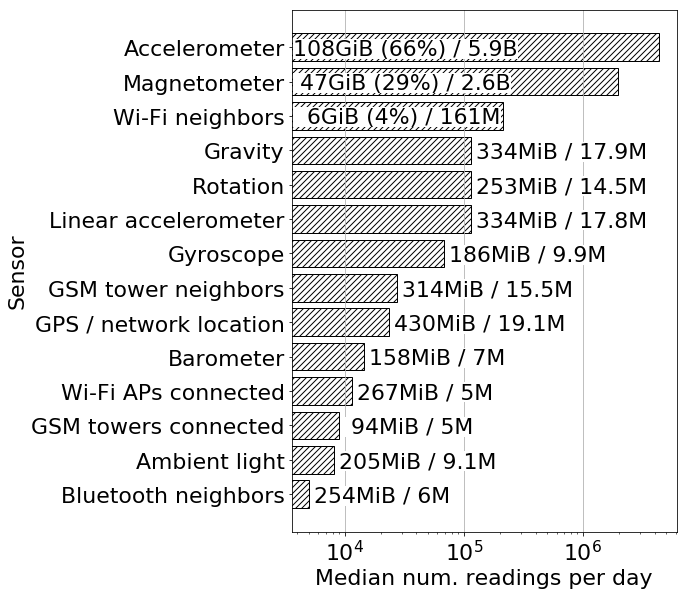

In [16]:
width_limit = 2e5
fig, ax = plt.subplots()
ypos = range(len(num_readings_per_day))
rects = ax.barh(ypos, list(num_readings_per_day.values()), fill=False, hatch="////")
for rect, sensor, y in zip(rects, num_readings_per_day, ypos):
    x = 3.7e3
    if num_readings_per_day[sensor] < width_limit:
        x = rect.get_width() + rect.get_width()*0.1
    sensor_data = data_sizes[data_sizes.Sensor == sensor]
    data_points = human_format(sensor_data["Total readings"].values[0])
    data_size = sizeof_fmt(sensor_data["Memory size"].values[0])
    data_ratio = sensor_data["Ratio"].values[0]
    if data_ratio > 0.01:
        text = "{} ({}) / {}".format(data_size, "{:.0%}".format(data_ratio), data_points)
    else:
        text = "{} / {}".format(data_size, data_points)
    ax.text(x, y-0.04, text, va="center", bbox=dict(boxstyle='square,pad=0', facecolor="white", edgecolor="none"))
ax.xaxis.grid()
ax.set_xscale("log")
ax.set_yticks(ypos)
ax.set_yticklabels([filter_label(label) for label in num_readings_per_day.keys()])
ax.set_ylabel("Sensor")
ax.set_xlabel("Median num. readings per day")
fig.set_figheight(fig.get_figheight()*2.4)
fig.set_figwidth(fig.get_figwidth()*1.15)
fig.savefig(get_plot_path("sensor-readings-per-day-total"), format=plot_format, bbox_inches="tight")

### Timelapse per sensor

In [17]:
sensor_day_readings = []
for sensor, data in df_data.items():
    if sensor in plot_data:
        value_counts = data.timestamp.dt.floor("d").value_counts()
        value_counts.name = "num_readings"
        df = series_to_df(value_counts)
        df.columns.values[0] = "day"
        df["sensor"] = sensor
        sensor_day_readings.append(df)
sensor_day_readings = pd.concat(sensor_day_readings)
sensor_day_readings.head()

,day,num_readings,sensor
0,2018-05-14,64073190,accelerometer
1,2018-05-15,58193190,accelerometer
2,2018-06-02,50231897,accelerometer
3,2018-05-16,37268494,accelerometer
4,2018-06-03,31495923,accelerometer


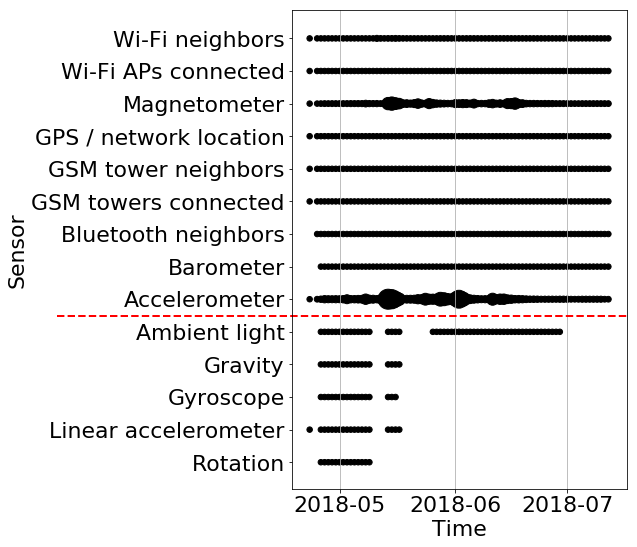

In [18]:
low_order = ["rotation", "linear_accelerometer", "gyroscope", "gravity", "light"]
sensors = dict()
fig, ax = plt.subplots()
scaler = scale_marker(sensor_day_readings.num_readings.values, (30, 400))
num_sensors = sensor_day_readings.sensor.unique().size
for sensor, records in sensor_day_readings.groupby("sensor"):
    records = records.sort_values(by=["day"])
    day = dates.date2num(records.day)
    size = scaler.transform(records.num_readings.values.reshape(-1, 1))
    if sensor in low_order:
        y = low_order.index(sensor)
    else:
        total = set(range(len(low_order), num_sensors, 1))
        taken = set(sensors.keys())
        y = list(total.difference(taken))[0]
    sensors[y] = sensor
    ax.scatter(day, [y] * len(day), size, color=default_color)
ax.axhline(len(low_order)-0.5, xmin=-0.7, linestyle="--", color="red", linewidth=2, clip_on=False)
#ax.axhline(len(low_order)-1.5, xmin=-0.7, linestyle="--", color="red", linewidth=2, clip_on=False)
ax.xaxis.grid()
ax.set_yticks(range(len(sensors)))
ax.set_yticklabels([filter_label(label) for _, label in sorted(sensors.items())])
ax.set_ylabel("Sensor")
ax.set_xlabel("Time")
ax.set_xticks([datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1)])
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))
# https://stackoverflow.com/questions/11264521/date-ticks-and-rotation-in-matplotlib
#ax.xaxis.set_tick_params(rotation=45)
#fig.autofmt_xdate()
fig.set_figheight(fig.get_figheight()*2.2)
fig.savefig(get_plot_path("sensor-readings-per-day-timelapse"), format=plot_format, bbox_inches="tight")

### Timelapse per device

In [19]:
device_day_readings = []
for sensor, data in df_data.items():
    if sensor in select_plot_data:
        data["day"] = data.timestamp.dt.floor("d")
        result = data.groupby(["day", "device_id"]).size()
        df = series_to_df(result)
        df.columns.values[-1] = "num_readings"
        device_day_readings.append(df)
device_day_readings = pd.concat(device_day_readings)
device_day_readings.head()

,day,device_id,num_readings
0,2018-04-23,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,6138
1,2018-04-25,3bbcc834-7c27-46b4-aa56-51267ab6e283,604154
2,2018-04-26,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,257250
3,2018-04-26,3bbcc834-7c27-46b4-aa56-51267ab6e283,1324535
4,2018-04-26,3dc6770c-ce88-406b-a53b-fa544d7bbb64,22882


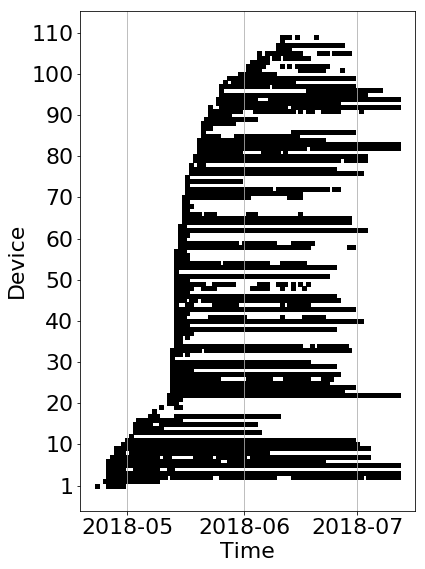

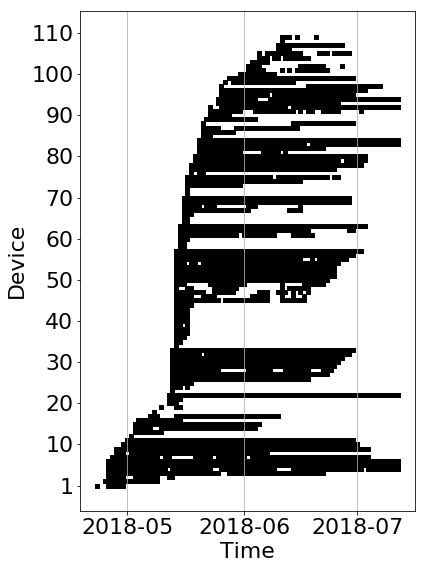

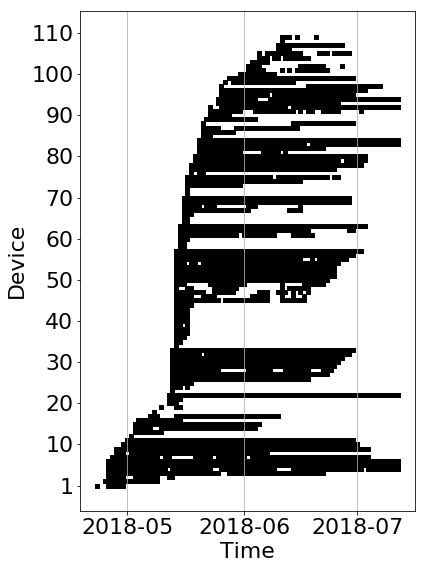

In [425]:
def plot(device_order, order_tag):
    fig, ax = plt.subplots()
    for device, records in device_day_readings.groupby("device_id"):
        records = records.sort_values(by=["day"])
        day = dates.date2num(records.day)
        cond = (device_order.device_id == device).values
        y = np.where(cond == True)[0][0]
        ax.scatter(day, [y] * len(records.day), 10, marker="s", color=default_color)
    ax.xaxis.grid()
    yticks = list(range(len(device_order)+1))[::10]
    ax.set_yticks(yticks)
    yticks[0] = 1
    ax.set_yticklabels(yticks)
    ax.set_ylabel("Device")
    ax.set_xlabel("Time")
    ax.set_xticks([datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1)])
    ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))
    #fig.autofmt_xdate()
    fig.set_figheight(fig.get_figheight()*2.3)
    fig.savefig(get_plot_path("sensor-readings-per-device-day-timelapse-" + order_tag), format=plot_format, bbox_inches="tight")

device_times = pd.DataFrame(columns=["device_id", "start", "end", "days"])
for device, records in device_day_readings.groupby("device_id"):
    start = min(records.day)
    end = max(records.day)
    days = (end-start).days + 1
    device_times.loc[len(device_times)] = [device, start, end, days]

device_sort_start_end = device_times.sort_values(by=["start"])
plot(device_sort_start_end, "start")

device_sort_start_days = device_times.sort_values(by=["start", "days"])
plot(device_sort_start_days, "start-days")

device_sort_start_end = device_times.sort_values(by=["start", "end"])
plot(device_sort_start_end, "start-end")

## Device activity

### Active devices per day

In [21]:
day_devices = []
for sensor, data in df_data.items():
    if sensor in select_plot_data:
        data["day"] = data.timestamp.dt.floor("d")
        day_devices.append(data[["day", "device_id"]])
day_devices = pd.concat(day_devices).groupby('day')['device_id'].nunique()
day_devices.head()

day
2018-04-23     1
2018-04-25     1
2018-04-26     7
2018-04-27     8
2018-04-28    10
Name: device_id, dtype: int64

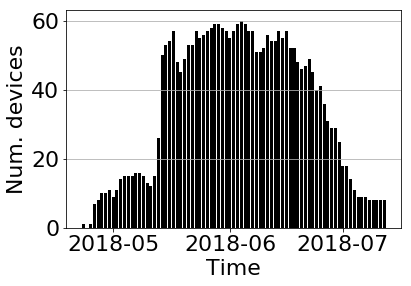

In [22]:
fig, ax = plt.subplots()
ax.bar(dates.date2num(day_devices.index), day_devices.values, color=default_color)
ax.set_ylabel("Num. devices")
ax.set_xlabel("Time")
ax.yaxis.grid()
ax.set_xticks([datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1)])
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))
#fig.autofmt_xdate()
fig.savefig(get_plot_path("active-devices-per-day"), format=plot_format, bbox_inches="tight")

### Total active devices

In [23]:
device_days = []
for sensor, data in df_data.items():
    if sensor in select_plot_data:
        data["day"] = data.timestamp.dt.floor("d")
        device_days.append(data[["day", "device_id"]])
device_days = pd.concat(device_days).groupby("device_id")["day"].nunique()
device_days.head()

device_id
056630a1-a0f1-4cab-9b10-37b03b3dc9ef    47
05bebd00-a408-4d3a-8d72-fe7f55ab7d8c    39
06ff292b-1e41-445f-9658-72d3834b2d1a     1
0836381c-48b0-43d9-9cf8-3273cbc8aecf    18
08ddf60e-af58-46a5-a040-deba1cf9cd5a     4
Name: day, dtype: int64

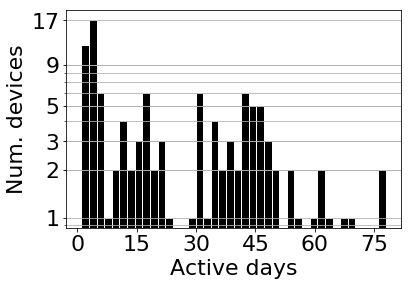

In [24]:
fig, ax = plt.subplots()
ax.hist(device_days.values, ec="white", bins=40, color=default_color)
ax.set_ylabel("Num. devices")
ax.set_xlabel("Active days")
ax.set_xticks(range(0, 85, 15))
ax.set_yscale("log")
ax.yaxis.grid(which='both')
yticks = [1, 2, 3, 5, 9, 17]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
fig.savefig(get_plot_path("active-devices-distribution"), format=plot_format, bbox_inches="tight")

## Device heterogeneity

In [140]:
coverage_threshold = 0.9

### Sensors hardware, vendors

In [141]:
total_sensor_vendors = []
hw_counts = collections.defaultdict(dict)
hw_details = collections.defaultdict(dict)
for name, data in df_hardware.items():
    data = data.drop_duplicates(subset="device_id")
    data = data.dropna(subset=["sensor_name", "sensor_vendor"])
    data.sensor_name = clean_sensor_names(data.sensor_name)
    data.sensor_vendor = adapt_strings(data.sensor_vendor, {"STMicroelectronics": "STM",
                                                            "Bosch Sensortec": "Bosch", "Bosch GMBH": "Bosch",
                                                            "Invensense INC.": "Invensense",
                                                            "HTC CORP.": "HTC",
                                                            "Intel INC.": "Intel",
                                                            "Alps Electric CO.,": "Alps",
                                                            "Yamaha Corporation": "Yamaha",
                                                            "Asahi Kasei Microdevices": "Asahi Kasei"})
    name = name.capitalize()
    hw_counts["num. devices"][name] = data.device_id.size
    hw_counts["unique sensors"][name] = data.sensor_name.replace('', np.nan).dropna().unique().size
    hw_counts["unique vendors"][name] = data.sensor_vendor.replace('', np.nan).dropna().unique().size
    hw_details[name]["sensor"] = data.sensor_name.value_counts(normalize=True)
    hw_details[name]["vendor"] = data.sensor_vendor.value_counts(normalize=True)
    total_sensor_vendors.append(data.sensor_vendor)
total_sensor_vendors = pd.concat(total_sensor_vendors)
print(hw_counts)
print(hw_details)

defaultdict(<class 'dict'>, {'num. devices': {'Accelerometer': 73, 'Barometer': 32, 'Magnetometer': 64}, 'unique sensors': {'Accelerometer': 22, 'Barometer': 9, 'Magnetometer': 20}, 'unique vendors': {'Accelerometer': 7, 'Barometer': 3, 'Magnetometer': 8}})
defaultdict(<class 'dict'>, {'Accelerometer': {'sensor': BMI160        0.178082
              0.164384
LSM6DS3       0.082192
BOSCH         0.054795
K6DS3TR       0.054795
BMA2X2        0.041096
MPU6500       0.041096
BMI120        0.041096
LSM6DSM       0.041096
LSM6DSL       0.041096
INVENSENSE    0.041096
K2HH          0.041096
LSM330        0.027397
BMC150        0.027397
MPL           0.013699
BMA254        0.013699
ICM20610      0.013699
K330          0.013699
LGE           0.013699
PSH           0.013699
KX023         0.013699
LIS3DH        0.013699
LSM330D       0.013699
Name: sensor_name, dtype: float64, 'vendor': BOSCH         0.438356
STM           0.356164
INVENSENSE    0.109589
KIONIX        0.041096
MTK           0.027

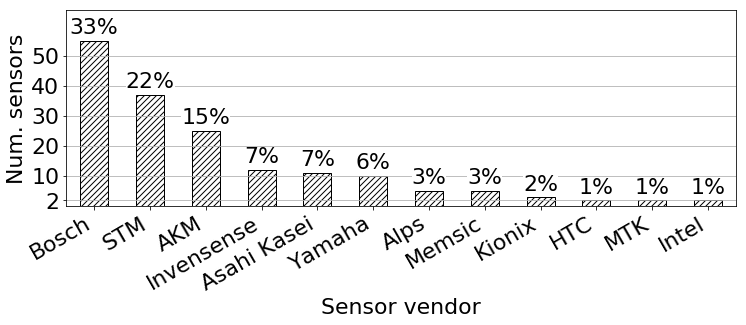

In [480]:
def title(value):
    return value if len(value) <=3 else value.title()
    
def autolabel(rects, ratios):
    for rect, ratio in zip(rects, ratios):
        height = rect.get_height()
        ax.annotate(ratio, xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                    bbox=dict(boxstyle='square,pad=0', facecolor="white", edgecolor="none"))

fig, ax = plt.subplots()
ax = total_sensor_vendors.apply(lambda x: title(x)).value_counts().plot(
    kind="bar", ax=ax, hatch="////", fill=False, edgecolor="black")
vendor_ratio = total_sensor_vendors.value_counts(normalize=True).map("{:.0%}".format)
autolabel(ax.patches, vendor_ratio)
ax.set_yticks([2, 10, 20, 30, 40, 50])
ax.set_ylabel("Num. sensors")
ax.set_xlabel("Sensor vendor")
ax.set_ylim(top=65)
ax.yaxis.grid()
fig.autofmt_xdate()
fig.set_figwidth(fig.get_figwidth()*2)
fig.savefig(get_plot_path("sensor-vendors"), format=plot_format, bbox_inches="tight")

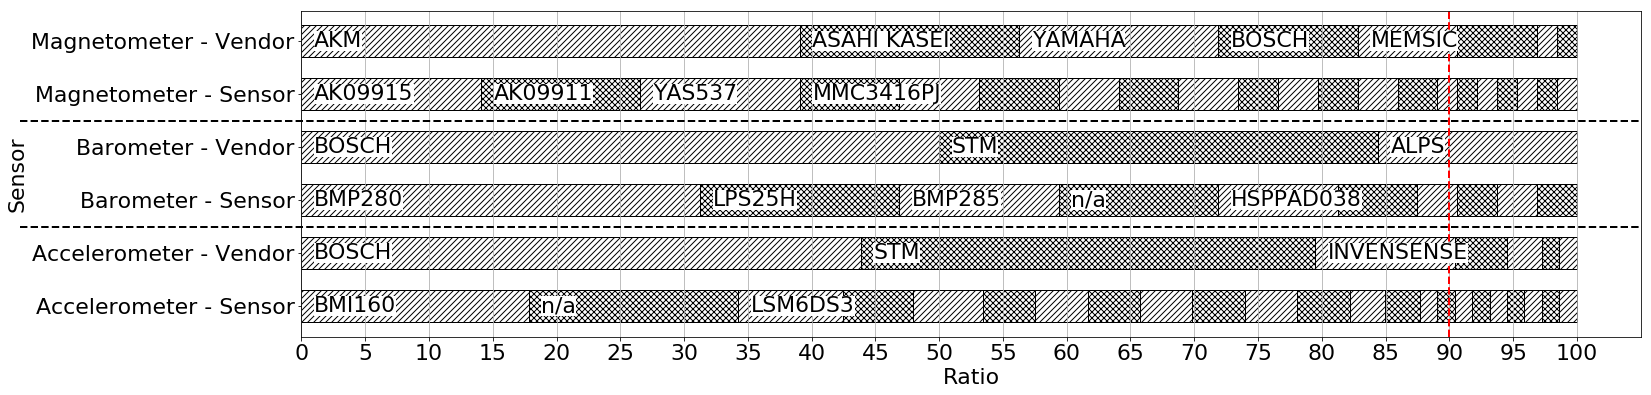

In [143]:
y = 0
labels = []
fig, ax = plt.subplots()
for sensor in hw_details:
    for details in hw_details[sensor]:
        data = hw_details[sensor][details]
        labels.append(sensor.capitalize() + " - " + details.capitalize())
        hatches = itertools.cycle(["////", "xxxx"])
        for i, (index, value) in enumerate(data.items()):
            left = sum(data[:i]) if i > 0 else 0
            value = value*100
            left = left*100
            rects = ax.barh(y, value, left=left, height=0.6, fill=False, hatch=next(hatches))
            for rect in rects:
                if value > 7:
                    desc = "n/a" if len(index) == 0 else index
                    ax.text(left+1, y, desc, va="center",
                            bbox=dict(boxstyle='square,pad=0', facecolor="white", edgecolor="none"))
        y += 1
        if y % 2 == 0 and y != 6:
            ax.axhline(y-0.5, xmin=-0.21, linewidth=2, linestyle="--", color="black", clip_on=False)

ax.axvline(coverage_threshold*100, linestyle="--", color="red", linewidth=2)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.xaxis.grid()
ax.set_xticks(range(0, 105, 5))
fig.set_figheight(fig.get_figheight()*1.5)
fig.set_figwidth(fig.get_figwidth()*4)
ax.set_ylabel("Sensor")
ax.set_xlabel("Ratio")
fig.savefig(get_plot_path("sensor-hardware-details"), format=plot_format, bbox_inches="tight")

Coverage threshold 90.0%
sensors
avg. unique sensors 17.0
avg. threshold sensors 11.0
decrease: 35%
vendors
avg. unique vendors 6.0
avg. threshold vendors 3.0
decrease: 50%


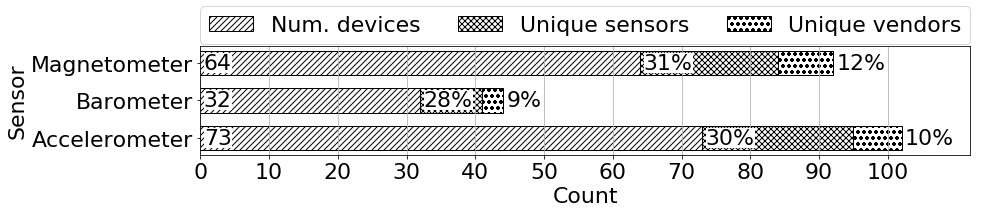

In [144]:
def autolabel(ax, rects, total=None, limit=9, xoffset=0.5):
    for i, rect in enumerate(rects):
        width = rect.get_width()
        format_value = "{:.0%}" if total else "{:.0f}"
        value = width / total[i] if total else width
        x = rect.get_x() + rect.get_width()+xoffset if width < limit else rect.get_x()+xoffset
        ax.text(x, i, format_value.format(value), va="center",
                bbox=dict(boxstyle='square,pad=0', facecolor="white", edgecolor="none"))

bar_height = 0.65
fig, ax = plt.subplots()
hatches = itertools.cycle(["////", "xxxx", "oo"])
for i, label in enumerate(hw_counts):
    sensors = list(hw_counts[label].keys())
    values = [hw_counts[label][sensor] for sensor in sensors]
    left = []
    for sensor in sensors:
        offsets = [hw_counts[var][sensor] for var in list(hw_counts.keys())[:i]]
        left.append(sum(offsets))
    total = [hw_counts["num. devices"][sensor] for sensor in sensors] if i > 0 else None
    bars = ax.barh(sensors, values, left=left, height=bar_height, label=label.capitalize(), fill=False, hatch=next(hatches))
    autolabel(ax, bars, total)
ax.set_xlim(right=112)
ax.xaxis.grid()
ax.set_xticks(range(0, 105, 10))
fig.set_figheight(fig.get_figheight()*0.5)
fig.set_figwidth(fig.get_figwidth()*2.3)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
ax.set_ylabel("Sensor")
ax.set_xlabel("Count")
fig.savefig(get_plot_path("sensor-hardware-distribution"), format=plot_format, bbox_inches="tight")

print("Coverage threshold {:.1%}".format(coverage_threshold))

unique_sensors = []
threshold_sensors = []
unique_vendors = []
threshold_vendors = []

for sensor_type in hw_details:
    data = hw_details[sensor_type]["sensor"]
    data = data[data.cumsum() <= coverage_threshold]
    na_sensors = len(np.where(data.index == "")[0])
    threshold_sensors.append(len(data) - na_sensors)
    unique_sensors.append(hw_counts["unique sensors"][sensor_type])
    data = hw_details[sensor_type]["vendor"]
    data = data[data.cumsum() <= coverage_threshold]
    na_vendors = len(np.where(data.index == "")[0])
    threshold_vendors.append(len(data) - na_vendors)
    unique_vendors.append(hw_counts["unique vendors"][sensor_type])
    
avg_unique_sensors = round(np.mean(unique_sensors), 0)
avg_threshold_sensors = round(np.mean(threshold_sensors), 0)
print("sensors")
print("avg. unique sensors", avg_unique_sensors)
print("avg. threshold sensors", avg_threshold_sensors)
print("decrease: {:.0%}".format(1-(avg_threshold_sensors / avg_unique_sensors)))

avg_unique_vendors = round(np.mean(unique_vendors), 0)
avg_threshold_vendors = round(np.mean(threshold_vendors), 0)
print("vendors")
print("avg. unique vendors", avg_unique_vendors)
print("avg. threshold vendors", avg_threshold_vendors)
print("decrease: {:.0%}".format(1-(avg_threshold_vendors / avg_unique_vendors)))

### Devices hardware, software

In [145]:
def adapt_labels(labels):
    new_labels = []
    for label in labels:
        whitespace = label.count(' ')
        uppercase = sum(1 for c in label if c.isupper())
        if whitespace == 0 and uppercase == 0:
            new_labels.append(label.capitalize())
        elif len(label) > 3 and len(label) == uppercase:
            new_labels.append(label.capitalize())
        else:
            new_labels.append(label)
    return new_labels

devices = df_data["aware_device"]
hw_columns = ["board", "brand", "device", "hardware", "manufacturer", "model", "product", "release_type", "sdk"]
devices[hw_columns].head()

,board,brand,device,hardware,manufacturer,model,product,release_type,sdk
0,marlin,google,marlin,marlin,Google,Pixel XL,marlin,user,27
1,bullhead,google,bullhead,bullhead,LGE,Nexus 5X,bullhead,user,27
2,sailfish,google,sailfish,sailfish,Google,Pixel,sailfish,user,27
3,Apple,iPhone,iPhone 6s,"iPhone8,1",Apple,iPhone,iPhone 6s,iPhone,11.3
4,Apple,iPhone,iPhone 7,"iPhone9,1",Apple,iPhone,iPhone 7,iPhone,11.3


In [473]:
#df_data["aware_device"].board.value_counts()

#df_data["aware_device"].brand.value_counts() == samsung
#df_data["aware_device"].manufacturer.value_counts() == samsung

#df_data["aware_device"].device.value_counts()
#df_data["aware_device"].hardware.value_counts()

#df_data["aware_device"].model.value_counts()
#df_data["aware_device"]["product"].value_counts()

#android = df_data["aware_device"][df_data["aware_device"].release_type == "user"]

devices = df_data["aware_device"].copy()
samsung = devices[devices.model.str.startswith("SM-", na=False)]
samsung.model.value_counts()

#devices.manufacturer = devices.manufacturer.str.lower()
#devices = devices[devices.manufacturer == "samsung"]
#devices.model.value_counts()

SM-G900F     3
SM-G930F     2
SM-A310F     2
SM-G935F     2
SM-A500FU    1
SM-G955U1    1
SM-G800F     1
SM-G532MT    1
SM-G950F     1
SM-A300FU    1
SM-N910C     1
SM-J510FN    1
SM-A510F     1
SM-A320FL    1
SM-P580      1
SM-N950F     1
SM-J700M     1
Name: model, dtype: int64

In [470]:
os_ratio = devices.release_type.value_counts(normalize=True)
os_ratio.index = np.where(os_ratio.index == "user", "Android", os_ratio.index)
os_ratio = os_ratio.map("{:.1%}".format)
os_ratio

Android    65.1%
iPhone     34.9%
Name: release_type, dtype: object

Coverage threshold 90.0%
Unique Android model: 15
Threshold Android model: 8
Ratio: 53%
samsung     0.280488
motorola    0.121951
OnePlus     0.097561
Google      0.085366
Sony        0.085366
LGE         0.073171
Xiaomi      0.073171
HUAWEI      0.073171
Name: manufacturer, dtype: float64
------------------------------
Unique Android release: 12
Threshold Android release: 5
Ratio: 42%
7.0      0.259259
8.1.0    0.172840
8.0.0    0.172840
6.0.1    0.160494
7.1.1    0.074074
Name: release, dtype: float64
------------------------------
Unique iOS model: 11
Threshold iOS model: 8
Ratio: 73%
iPhone            0.204545
iPhone 6          0.159091
iPhone 6s         0.159091
iPhone 7          0.113636
iPhone SE         0.068182
iPhone 7 Plus     0.068182
iPhone 5s         0.068182
iPhone 6s Plus    0.045455
Name: product, dtype: float64
------------------------------
Unique iOS release: 12
Threshold iOS release: 7
Ratio: 58%
11.3.1    0.318182
11.3      0.250000
11.2.6    0.090909
11.2.1    0.

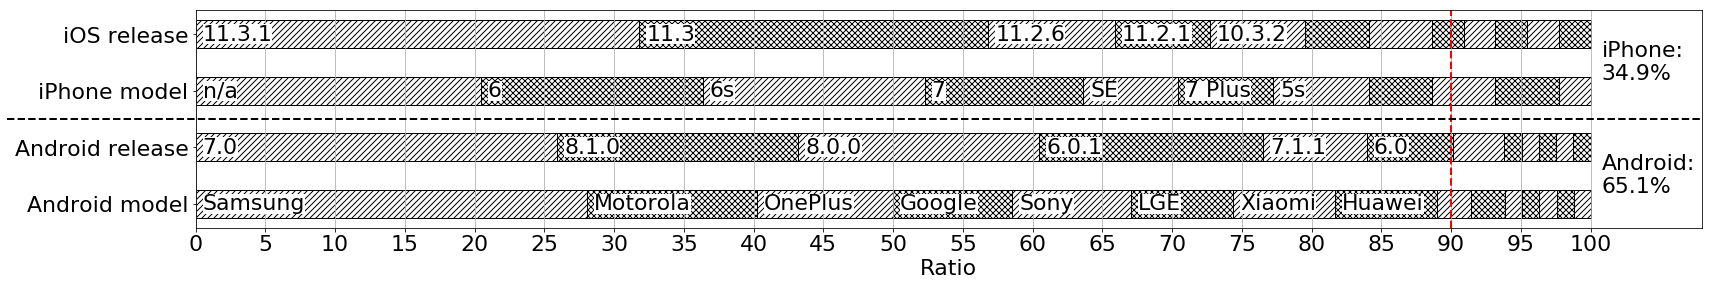

In [147]:
def plotbar(y, data):
    hatches = itertools.cycle(["////", "xxxx"])
    for i, (index, value) in enumerate(data.items()):
        left = sum(data[:i]) if i > 0 else 0
        value = value*100
        left = left*100
        rects = ax.barh(y, value, left=left, height=0.5, fill=False, hatch=next(hatches))
        for rect in rects:
            if value > 5:
                label = adapt_labels([index])[0].replace("iPhone", "").strip()
                label = "n/a" if len(label) == 0 else label
                ax.text(left+0.5, y, label, va="center",
                        bbox=dict(boxstyle='square,pad=0', facecolor="white", edgecolor="none"))

def get_platform_ratio(platform):
    return platform + ":\n" + os_ratio[platform]

android = devices[devices.release_type == "user"]
android_manufacturer = android.manufacturer.value_counts(normalize=True)
android_release = android.release.value_counts(normalize=True)
ios = devices[devices.release_type == "iPhone"]
ios_product = ios["product"].value_counts(normalize=True)
ios_sdk = ios.sdk.value_counts(normalize=True)

fig, ax = plt.subplots()
summary = [("Android model", android_manufacturer), ("Android release", android_release),
           ("iPhone model", ios_product), ("iOS release", ios_sdk)]
ypos = range(len(summary))
for i, (_, data) in enumerate(summary):
    plotbar(ypos[i], data)
ax.set_yticks(ypos)
ax.set_yticklabels([ylabel for ylabel, _ in summary])
ax.xaxis.grid()
ax.set_xlabel("Ratio")
ax.set_xticks(range(0, 105, 5))
ymid = ypos[1] + (ypos[2]-ypos[1])/2
ax.axvline(coverage_threshold*100, linestyle="--", color="red", linewidth=2)
ax.axhline(ymid, xmin=-0.125, linewidth=2, linestyle="--", color="black", clip_on=False)
xpos = 100.8
ax.text(xpos, 0.2, get_platform_ratio("Android"))
ax.text(xpos, 2.2, get_platform_ratio("iPhone"))
ax.set_xlim(right=108)
fig.set_figwidth(fig.get_figwidth()*4.5)
fig.savefig(get_plot_path("device-model-os-distribution"), format=plot_format, bbox_inches="tight")

print("Coverage threshold {:.1%}".format(coverage_threshold))

unique = len(android_manufacturer)
threshold = android_manufacturer[android_manufacturer.cumsum() <= coverage_threshold]
print("Unique Android model:", unique)
print("Threshold Android model:", len(threshold))
print("Ratio: {:.0%}".format(len(threshold)/unique))
print(threshold)
print("------------------------------")

unique = len(android_release)
threshold = android_release[android_release.cumsum() <= coverage_threshold]
print("Unique Android release:", unique)
print("Threshold Android release:", len(threshold))
print("Ratio: {:.0%}".format(len(threshold)/unique))
print(threshold)
print("------------------------------")

unique = len(ios_product)
threshold = ios_product[ios_product.cumsum() <= coverage_threshold]
print("Unique iOS model:", unique)
print("Threshold iOS model:", len(threshold))
print("Ratio: {:.0%}".format(len(threshold)/unique))
print(threshold)
print("------------------------------")

unique = len(ios_sdk)
threshold = ios_sdk[ios_sdk.cumsum() <= coverage_threshold]
print("Unique iOS release:", unique)
print("Threshold iOS release:", len(threshold))
print("Ratio: {:.0%}".format(len(threshold)/unique))
print(threshold)

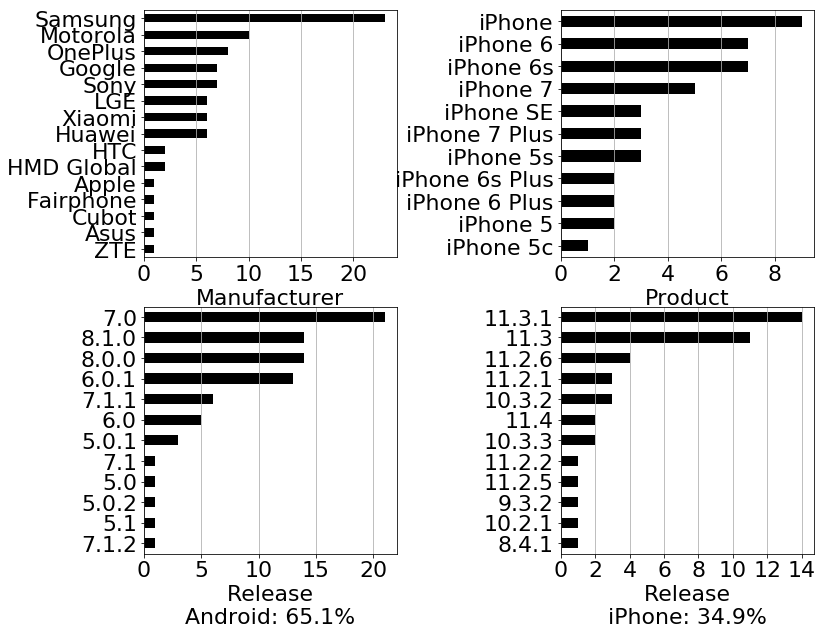

In [148]:
def plotbar(data, ax, xlabel, multiple_locator, change_labels=False):
    value_counts = data.value_counts(ascending=True)
    if change_labels:
        value_counts.index = adapt_labels(value_counts.index)
    value_counts.plot.barh(ax=ax, color=default_color)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(multiple_locator))
    ax.xaxis.grid()
    ax.set_xlabel(xlabel)
    
def get_xlabel(label, platform):
    return label + "\n" + platform + ": " + os_ratio[platform]

fig, ax = plt.subplots(nrows=2, ncols=2)
android = devices[devices.release_type == "user"]
plotbar(android.manufacturer, ax[0][0], "Manufacturer", 5, True)
plotbar(android.release, ax[1][0], get_xlabel("Release", "Android"), 5)
ios = devices[devices.release_type == "iPhone"]
plotbar(ios["product"], ax[0][1], "Product", 2)
plotbar(ios.sdk, ax[1][1], get_xlabel("Release", "iPhone"), 2)
fig.set_figheight(fig.get_figheight()*2.5)
fig.set_figwidth(fig.get_figwidth()*2)
fig.subplots_adjust(wspace=0.65)
fig.savefig(get_plot_path("hw-sw-overview"), format=plot_format, bbox_inches="tight")

### Missing sensor hardware

In [18]:
df_hardware.keys()

dict_keys(['accelerometer', 'barometer', 'magnetometer'])

In [161]:
# manufacturer not precise enough, only if vendor uses all the time the same sensor which is not true
# sensor data mainly from apple and hardware data only from android, no apple hardware

# to get sensor hardware there are two different ways
# via manufacturer, if only one sensor or take majority >= 0.9
# model <> sensor check that for each model only one sensor
# last step merge with sensor data, check the ratio and amount of sensor devices

print("Sensors per vendor")
for sensor in df_hardware:
    sensor_hardware = df_data["aware_device"].merge(df_hardware[sensor], left_on="device_id", right_on="device_id")
    for manufacturer, records in sensor_hardware.groupby("manufacturer"):
        sensors = records.sensor_name.value_counts()
        print(manufacturer)
        print(sensors)

Sensors per vendor
CUBOT
ACCELEROMETER    1
Name: sensor_name, dtype: int64
Fairphone
LSM330D Accelerometer    1
Name: sensor_name, dtype: int64
Google
BMI160 accelerometer     4
LSM6DSM Accelerometer    2
Name: sensor_name, dtype: int64
HTC
BMI160 Accelerometer    1
Accelerometer Sensor    1
Name: sensor_name, dtype: int64
HUAWEI
accelerometer                  2
LSM330 3-axis Accelerometer    2
accelerometer-kx023            1
Name: sensor_name, dtype: int64
LGE
BMI160 accelerometer    4
LGE Accelerometer       1
Name: sensor_name, dtype: int64
OnePlus
LSM6DS3 Accelerometer    5
BMI160 Accelerometer     2
LIS3DH Accelerometer     1
Name: sensor_name, dtype: int64
Sony
BMA2X2 Accelerometer/Temperature/Double-tap    3
Invensense Accelerometer                       3
LSM6DSM Accelerometer                          1
Name: sensor_name, dtype: int64
Xiaomi
BMI120 Accelerometer     3
LSM6DS3 Accelerometer    1
BMI160 Accelerometer     1
Name: sensor_name, dtype: int64
ZTE
Bosch Accelerometer

In [162]:
print("Overlap between devices' sensor data and devices' sensor hardware")
for sensor in df_hardware:
    devices_sensor_data = pd.DataFrame({"device_id": df_data[sensor].device_id.unique()}).merge(df_data["aware_device"], left_on="device_id", right_on="device_id")
    devices_hardware = df_hardware[sensor].merge(df_data["aware_device"], left_on="device_id", right_on="device_id")
    print(sensor)
    print("sensor data from devices")
    print(devices_sensor_data.manufacturer.value_counts())
    print("sensor hardware from devices")
    print(devices_hardware.manufacturer.value_counts())
    print("---")

Overlap between devices' sensor data and devices' sensor hardware
accelerometer
sensor data from devices
Apple        34
samsung      22
motorola      9
OnePlus       8
Google        7
Sony          7
Xiaomi        5
LGE           5
HUAWEI        5
HTC           2
ZTE           1
Fairphone     1
CUBOT         1
asus          1
Name: manufacturer, dtype: int64
sensor hardware from devices
samsung      22
motorola      9
OnePlus       8
Sony          7
Google        6
Xiaomi        5
LGE           5
HUAWEI        5
HTC           2
ZTE           1
Fairphone     1
CUBOT         1
asus          1
Name: manufacturer, dtype: int64
---
barometer
sensor data from devices
Apple     26
Google     1
Name: manufacturer, dtype: int64
sensor hardware from devices
samsung    13
Sony        7
Google      6
LGE         5
Xiaomi      1
Name: manufacturer, dtype: int64
---
magnetometer
sensor data from devices
Apple        34
samsung      18
OnePlus       8
Google        7
Sony          7
LGE           5


In [165]:
print("For which devices in sensor data we have the sensor hardware")

total_manufacturer_missing_hardware = []
total_model_missing_hardware = []
total_product_missing_hardware = []

for sensor in df_hardware:
    
    devices_sensor_data = df_data[sensor].device_id.unique()
    devices_hardware_data = df_hardware[sensor].device_id.unique()
    
    overlap_devices_data_hardware = np.intersect1d(devices_sensor_data, df_hardware[sensor].device_id)
    devices_missing_hardware = np.setdiff1d(devices_sensor_data, df_hardware[sensor].device_id)
    
    assert len(overlap_devices_data_hardware) + len(devices_missing_hardware) == len(devices_sensor_data)
    
    print(sensor)
    print("devices sensor data:", len(devices_sensor_data))
    print("devices hardware data:", len(devices_hardware_data))
    print("devices sensor data with hardware:", len(overlap_devices_data_hardware))
    print("ratio devices sensor data with hardware : {:.2%}".format(len(overlap_devices_data_hardware) / len(devices_sensor_data)))
    
    devices_missing_hardware = pd.DataFrame({"device_id": devices_missing_hardware}).merge(df_data["aware_device"], left_on="device_id", right_on="device_id")
    
    print("### Details about missing hardware")
    print("os ratio:", devices_missing_hardware.release_type.value_counts(normalize=True).map("{:.1%}".format))
    print("manufacturer:", devices_missing_hardware.manufacturer.value_counts())
    print("model:", devices_missing_hardware.model.value_counts())
    print("product:", devices_missing_hardware["product"].value_counts())
    print("-----------------")
    
    total_manufacturer_missing_hardware.append(devices_missing_hardware.manufacturer)
    total_model_missing_hardware.append(devices_missing_hardware.model)
    total_product_missing_hardware.append(devices_missing_hardware["product"])

print("Total missing hardware")
print("manufacturer:", pd.concat(total_manufacturer_missing_hardware).value_counts())
print("model:", pd.concat(total_model_missing_hardware).value_counts())
print("product:", pd.concat(total_product_missing_hardware).value_counts())

For which devices in sensor data we have the sensor hardware
accelerometer
devices sensor data: 108
devices hardware data: 73
devices sensor data with hardware: 73
ratio devices sensor data with hardware : 67.59%
### Details about missing hardware
os ratio: iPhone    97.1%
user       2.9%
Name: release_type, dtype: object
manufacturer: Apple     34
Google     1
Name: manufacturer, dtype: int64
model: iPhone      34
Pixel XL     1
Name: model, dtype: int64
product: iPhone            7
iPhone 6s         5
iPhone 6          4
iPhone 7          4
iPhone SE         3
iPhone 5s         3
iPhone 7 Plus     3
iPhone 5          2
iPhone 6s Plus    2
marlin            1
iPhone 6 Plus     1
Name: product, dtype: int64
-----------------
barometer
devices sensor data: 27
devices hardware data: 32
devices sensor data with hardware: 1
ratio devices sensor data with hardware : 3.70%
### Details about missing hardware
os ratio: iPhone    100.0%
Name: release_type, dtype: object
manufacturer: Apple    2

## User's mobility
* Use encounters of Wi-Fi access points and Bluetooth beacons to calculate walking distance over all users
* Use the entropy over the user's mobility for proximity detection
* broadcast address of AP scans != AP MAC of connected client (increase by 2 per SSID)

In [742]:
# https://radiocells.org/default/wiki
dbpath = os.path.join(path_data_collection, "cell-tower.sqlite")
db = sqlite3.connect(dbpath)
cell_towers_radiocells = pd.read_sql_query("SELECT * from cell_zone", db)
cell_towers_radiocells.cid = cell_towers_radiocells.cid.astype(int)
cell_towers_radiocells = cell_towers_radiocells[cell_towers_radiocells.technology == "GSM"]
db.close()

# https://opencellid.org/downloads.php  
cell_towers_opencellid = pd.read_csv(os.path.join(path_data_collection, "cell-tower.csv.gz"))
cell_towers_opencellid = cell_towers_opencellid[cell_towers_opencellid.radio.str.upper() == "GSM"]

opencellid = df_data["gsm"].merge(cell_towers_opencellid, left_on="cid", right_on="cell")
opencellid = opencellid.lon.dropna().size
radiocells = df_data["gsm"].merge(cell_towers_radiocells, left_on="cid", right_on="cid")
radiocells = radiocells.longitude.dropna().size
print("Size radiocells:", radiocells)
print("Size opencellid:", opencellid)
"{:.1%}".format(radiocells/opencellid)

Size radiocells: 121815
Size opencellid: 1850825


'6.6%'

In [35]:
position_columns = {"bluetooth": ["lat", "long"],
            "wifi": ["lat", "long"],
            #"gsm": ["lat", "lon"] for opencellid towers
            "gsm": ["latitude", "longitude"],
            "gps": ["lat", "lng"],
            "network": ["lat", "lng"]
            }

position_join = [("bluetooth", "bt_address", "bluetooth", "mac"),
             ("wifi", "bssid", "wifi", "mac"),
             ("sensor_wifi", "bssid", "wifi", "mac"),
             ("gsm", "cid", "gsm", "cid"), # cell, cid
             ("gsm_neighbor", "cid", "gsm", "cid") # cell, cid
            ]
neighbor_scans = ["bluetooth", "wifi", "gsm_neighbor"]

In [36]:
user_distances = dict()
user_entropies = collections.defaultdict(dict)

# https://stackoverflow.com/questions/57325537/compute-entropy-of-a-set-of-points
# https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy(x):
    counts = np.histogramdd(x)[0]
    dist = counts / np.sum(counts)
    logs = np.log2(np.where(dist > 0, dist, 1))
    return -np.sum(dist * logs)

#from sklearn.neighbors.kde import KernelDensity
#kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(pos)
#log_p = kde.score_samples(pos)   # returns log(p) of data sample
#p = np.exp(log_p)                # estimate p of data sample
#entropy = -np.sum(p*log_p)       # evaluate entropy
#print(entropy)

def compute_distances(device_id, records, temp_distances, temp_entropy, pos_data, max_daily_walk_distance=300000):
    records = records.sort_values(by=["timestamp"])
    records = records.dropna(subset=position_columns[pos_data])
    pos_data = records[position_columns[pos_data]]
    walk_distances = apply_distance_rowwise(pos_data, geodesic)
    walk_distance = sum(walk_distances)
    #temp_entropy[device_id].append(entropy(pos_data.values))
    if walk_distance < max_daily_walk_distance: # filter outlier and noise
        temp_distances.append(walk_distance)
        temp_entropy[device_id].append(entropy(pos_data.values))

### GPS and Network Location

In [37]:
print(df_data["locations"].provider.value_counts())

for provider in ["gps", "network"]:
    print("data: {}".format(provider))
    locations = df_data["locations"][df_data["locations"].provider == provider].copy()
    locations["day"] = locations.timestamp.dt.floor("d")
    temp_distances = []
    temp_entropy = collections.defaultdict(list)
    for (device_id, day), records in locations.groupby(["device_id", "day"]):
        if records.lat.nunique() > 1:
            compute_distances(device_id, records, temp_distances, temp_entropy, provider)
    
    user_distances[provider] = temp_distances
    for device, entropies in temp_entropy.items():
        user_entropies[provider][device] = np.mean(entropies)

gps        991306
network    749510
Name: provider, dtype: int64
data: gps
data: network


### Bluetooth, Wi-Fi, GSM

In [38]:
for src_data, src_join, pos_data, pos_join in position_join:
    print("data: {}".format(src_data))
    sensor_data = df_data[src_data][["timestamp", "device_id", src_join]].copy()
    positions = df_pos[pos_data].copy()
    if sensor_data[src_join].dtype == np.object: # string
        if src_data == "sensor_wifi":
            sensor_data[src_join] = sensor_data[src_join].str[:-1].str.upper()
            positions[pos_join] = positions[pos_join].str[:-1].str.upper()
        else:
            sensor_data[src_join] = sensor_data[src_join].str.upper()
            positions[pos_join] = positions[pos_join].str.upper()
    sensor_data = sensor_data.merge(positions, left_on=src_join, right_on=pos_join)
    sensor_data["day"] = sensor_data.timestamp.dt.floor("d")
    temp_distances = []
    temp_entropy = collections.defaultdict(list)
    for (device_id, day), records in sensor_data.groupby(["device_id", "day"]):
        if records[src_join].nunique() > 1:
            if any([src_data == scan for scan in neighbor_scans]): # take mean of grouped scans by median sampling time
                records = records.sort_values(by=["timestamp"])
                median_sampling_time = int(records.timestamp.diff().median().total_seconds())
                if median_sampling_time > 10: # seconds
                    records = records.resample("{}S".format(median_sampling_time), on="timestamp").mean()
                    compute_distances(device_id, records, temp_distances, temp_entropy, pos_data)
            else:
                compute_distances(device_id, records, temp_distances, temp_entropy, pos_data)
    
    user_distances[src_data] = temp_distances
    for device, entropies in temp_entropy.items():
        user_entropies[src_data][device] = np.mean(entropies)

data: bluetooth
data: wifi
data: sensor_wifi
data: gsm
data: gsm_neighbor


### User walking distance

dict_keys(['gps', 'network', 'bluetooth', 'wifi', 'sensor_wifi', 'gsm', 'gsm_neighbor', 'network-gps'])


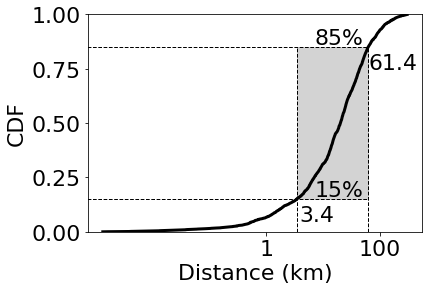

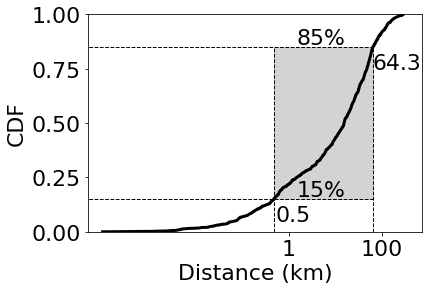

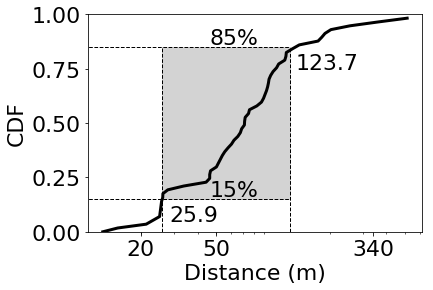

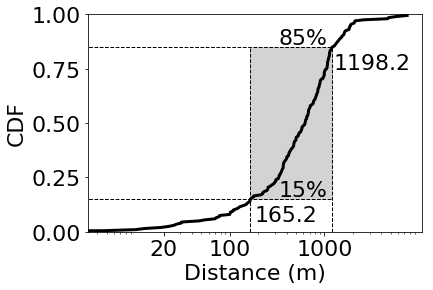

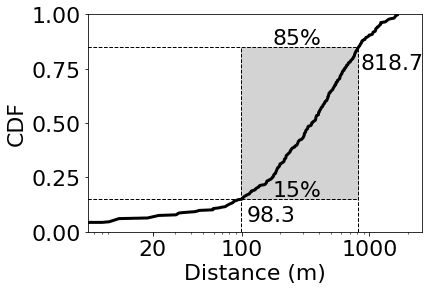

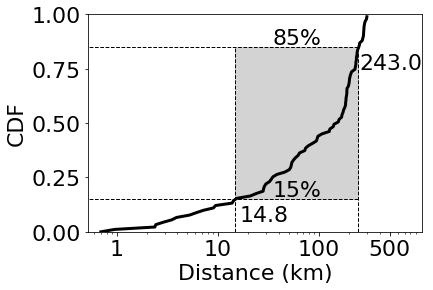

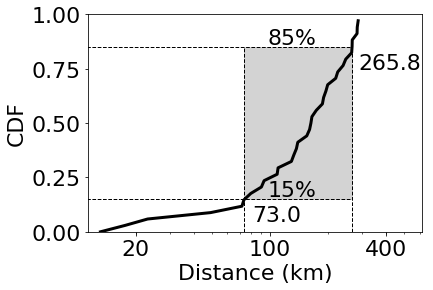

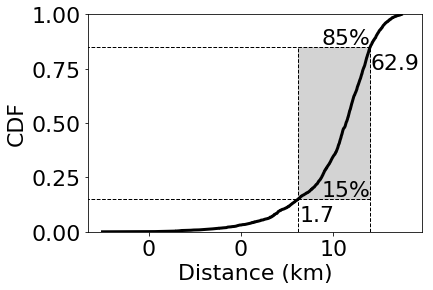

In [39]:
linewidth = 1
linestyle = "--"
text_shift = 0.015
linecolor = "black"
upper_threshold = 0.85
lower_threshold = 0.15
yshift = 0.1
background_color = "lightgrey"
km = ["gps", "network", "gsm"]
xlim = {"gsm": 1050, "gsm_neighbor": 620, "network": 750, "sensor_wifi": 2600, "network-gps": 850}
xticks = {"sensor_wifi": [20, 100, 1000], "wifi": [20, 100, 1000],
          "gsm": [1, 10, 100, 500], "gsm_neighbor": [20, 100, 400],
         "gps": [1, 100], "network": [1, 100],
          "bluetooth": [20, 50, 340]}

user_distances["network-gps"] = user_distances["network"] + user_distances["gps"]
print(user_distances.keys())

for sensor, distances in user_distances.items():    
    distance_unit = "m"
    if any(data in sensor for data in km):
        distance_unit = "km"
        distances = [dist/1000.0 for dist in distances]
    
    fig, ax = plt.subplots()
    upper_quantile = pd.Series(distances).quantile(upper_threshold)
    lower_quantile = pd.Series(distances).quantile(lower_threshold)
    powerlaw.plot_cdf(distances, ax=ax, color=default_color)
    
    ax.vlines(lower_quantile, ymin=0, ymax=upper_threshold, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    ax.vlines(upper_quantile, ymin=0, ymax=upper_threshold, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    ax.hlines(upper_threshold, xmin=0, xmax=upper_quantile, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    ax.hlines(lower_threshold, xmin=0, xmax=upper_quantile, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    
    ax.axvspan(xmin=lower_quantile, xmax=upper_quantile, ymin=lower_threshold, ymax=upper_threshold, color=background_color)
    
    mid = pd.Series(distances).quantile(0.25)
    ax.annotate(s="{:.0%}".format(lower_threshold), xy=(mid, lower_threshold+text_shift))
    ax.annotate(s="{:.0%}".format(upper_threshold), xy=(mid, upper_threshold+text_shift))
    
    ax.annotate(s='{:.1f}'.format(upper_quantile), xy=(upper_quantile+lower_quantile*0.32, upper_threshold-yshift))
    ax.annotate(s='{:.1f}'.format(lower_quantile), xy=(lower_quantile+lower_quantile*0.1, lower_threshold-yshift))
    
    ax.set_yscale("linear")
    ax.set_ylim(0, 1)
    ax.set_ylabel("CDF")
    ax.set_xlabel("Distance ({})".format(distance_unit))
    
    if sensor in xticks:
        ax.set_xticks(xticks[sensor])
    if sensor in xlim:
        ax.set_xlim(right=xlim[sensor])
    
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax.xaxis.set_major_formatter(formatter)
    
    fig.savefig(get_plot_path("user-walking-distance-per-day-" + sensor.replace("_", "-")),
                format=plot_format, bbox_inches="tight")

### Randomness of user behavior

In [40]:
from sklearn.cluster import KMeans
for src_data, device_entropy in user_entropies.items():
    devices = np.asarray(list(device_entropy.keys()))
    entropy = np.asarray(list(device_entropy.values())).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(entropy)
    cluster1 = devices[np.where(kmeans.labels_==1)]
    cluster0 = devices[np.where(kmeans.labels_==0)]
    print(src_data)
    print(kmeans.cluster_centers_)
    #print(len(device_entropy))
    print(len(cluster1))
    print(len(cluster0))

gps
[[3.05210335]
 [1.86047852]]
73
24
network
[[1.36913706]
 [2.91111455]]
11
53
bluetooth
[[1.03841094]
 [1.73327565]]
2
11
wifi
[[2.61454668]
 [1.66059498]]
12
23
sensor_wifi
[[0.68820021]
 [1.52540688]]
29
20
gsm
[[1.03244538]
 [0.43575523]]
7
18
gsm_neighbor
[[1.02002661]
 [1.64624063]]
2
16


In [41]:
high_entropy = []
users_high_entropy = []
low_entropy = []
users_low_entropy = []
amount_initial_centers = 2

user_clusters = collections.defaultdict(dict)

for src_data, device_entropy in user_entropies.items():
    devices = np.asarray(list(device_entropy.keys()))
    entropy = np.asarray(list(device_entropy.values())).reshape(-1, 1)
    initial_centers = kmeans_plusplus_initializer(entropy, amount_initial_centers).initialize()
    xmeans_instance = xmeans(entropy, initial_centers)
    xmeans_instance.process()
    centers = xmeans_instance.get_centers()
    
    missing_devices = set(df_data["aware_device"].device_id) - set(devices)
    cluster_lens = list(map(len, xmeans_instance.get_clusters()))
    
    for center, cluster in zip(xmeans_instance.get_centers(), xmeans_instance.get_clusters()):
        cluster_devices = list(devices[cluster])
        #if len(cluster) == min(cluster_lens):
        #    cluster_devices.extend(missing_devices)
        user_clusters[src_data][center[0]] = cluster_devices
    
    print("### " + src_data)
    print("num devices", len(device_entropy))
    print("num clusters", len(centers))
    print("missing devices", len(missing_devices))
    print("cluster len orignal", cluster_lens)
    print("cluster len extended", list(map(len, user_clusters[src_data].values())))
    
    if len(centers) == 2:
        mean_entropy = np.mean(centers)    
        for entropy, cluster_idx in zip(centers, xmeans_instance.get_clusters()):
            cluster_devices = devices[cluster_idx]
            if entropy > mean_entropy:
                high_entropy.append(entropy)
                users_high_entropy.append(cluster_devices)
            else:
                low_entropy.append(entropy)
                users_low_entropy.append(cluster_devices)

selected_src_data = "gps"
user_groups = user_clusters[selected_src_data]
average_user_entropy = np.mean(list(user_entropies[selected_src_data].values()))
user_groups[average_user_entropy] = None

print("average user entropy", average_user_entropy)

print("### selected user groups")
for group1, group2 in itertools.combinations(user_groups.values(), 2):
    if group1 != None and group2 != None:
        intersection = set(group1).intersection(set(group2))
        print("group size 1", len(group1))
        print("group size 2", len(group2))
        print("overlap", len(intersection))

for entropy, devices in user_groups.items():
    if devices != None:
        print("entropy", round(entropy, 2), "num. devices", len(devices))

### gps
num devices 97
num clusters 2
missing devices 29
cluster len orignal [73, 24]
cluster len extended [73, 24]
### network
num devices 64
num clusters 2
missing devices 62
cluster len orignal [11, 53]
cluster len extended [11, 53]
### bluetooth
num devices 13
num clusters 2
missing devices 113
cluster len orignal [4, 9]
cluster len extended [4, 9]
### wifi
num devices 35
num clusters 2
missing devices 91
cluster len orignal [12, 23]
cluster len extended [12, 23]
### sensor_wifi
num devices 49
num clusters 2
missing devices 77
cluster len orignal [21, 28]
cluster len extended [21, 28]
### gsm
num devices 25
num clusters 3
missing devices 101
cluster len orignal [16, 2, 7]
cluster len extended [16, 2, 7]
### gsm_neighbor
num devices 18
num clusters 5
missing devices 108
cluster len orignal [12, 1, 3, 1, 1]
cluster len extended [12, 1, 3, 1, 1]
average user entropy 2.1553135311816405
### selected user groups
group size 1 73
group size 2 24
overlap 0
entropy 1.86 num. devices 73
entro

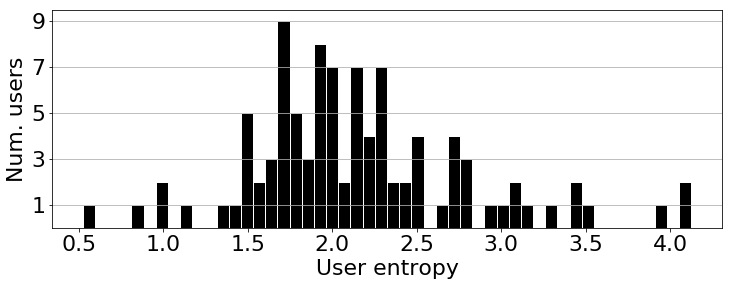

In [149]:
fig, ax = plt.subplots()
ax.hist(user_entropies[selected_src_data].values(), ec="white", bins=50, color=default_color)
ax.set_ylabel("Num. users")
ax.set_xlabel("User entropy")
ax.yaxis.grid()
yticks = [1, 3, 5, 7, 9]
ax.set_yticks(yticks)
fig.set_figwidth(fig.get_figwidth()*2)
fig.savefig(get_plot_path("user-entropy-distribution"), format=plot_format, bbox_inches="tight")

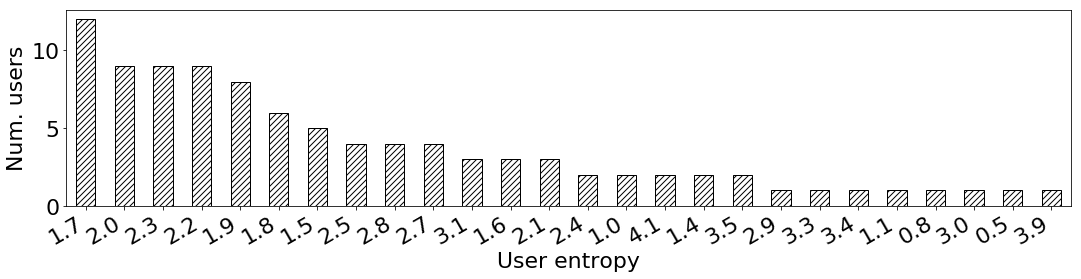

In [43]:
fig, ax = plt.subplots()
data = pd.Series(list(user_entropies[selected_src_data].values()))
ax = data.round(1).value_counts().plot(kind="bar", hatch="////", fill=False, edgecolor="black", ax=ax)
ax.set_ylabel("Num. users")
ax.set_xlabel("User entropy")
fig.autofmt_xdate()
fig.set_figwidth(fig.get_figwidth()*3)

## Ground truth correlation

In [164]:
def relabel(df):    
    df.index = [filter_label(label) for label in df.index]
    df.columns = [filter_label(label) for label in df.columns]
    return df

def compare_ground_truth(result, proximity, non_proximity):
    
    def compare(g1, g2):
        correlation = []
        if len(g1) != len(g2):
            vector_length = min(len(g1), len(g2))
            for _ in range(10):
                g1_test = sorted(random.sample(g1, vector_length))
                g2_test = sorted(random.sample(g2, vector_length))
                correlation.append(stats.pearsonr(g1_test, g2_test)[0])
        else:
            correlation.append(stats.pearsonr(g1, g2)[0])
        return np.mean(correlation)
    
    for g1, g2 in itertools.combinations(result, 2):
        g1_proximity, g1_non_proximity = result[g1]
        g2_proximity, g2_non_proximity = result[g2]
        proximity[g1][g2].append(compare(g1_proximity, g2_proximity))
        non_proximity[g1][g2].append(compare(g1_non_proximity, g2_non_proximity))
    
def heatmap(df, filename):
    fig, ax = plt.subplots()
    sns.heatmap(df, annot=True, cmap="jet", linewidths=1, vmin=0, vmax=1, ax=ax) # jet, Greens
    fig.autofmt_xdate() # tick orientation
    fig.savefig(get_plot_path("ground-truth-correlation-" + filename), format=plot_format, bbox_inches="tight")

In [165]:
le = preprocessing.LabelEncoder()
le.fit(df_data["aware_device"].device_id)
start_time_window = min([df_data[ground_truth].timestamp.iloc[0] for ground_truth in ground_truths])
end_time_condition = max([df_data[ground_truth].timestamp.iloc[-1] for ground_truth in ground_truths])
end_time_window = start_time_window + timedelta_evaluation

found_ground_truth = list()
proximity = nested_dict(2, list)
non_proximity = nested_dict(2, list)
group_size_proximity = collections.defaultdict(list)
group_size_non_proximity = collections.defaultdict(list)

while start_time_window < end_time_condition:
    analysis = dict()
    for ground_truth, group_field in ground_truths.items():
        ground_truth_data = df_data[ground_truth]
        ground_truth_selection = ground_truth_data[(ground_truth_data.timestamp >= start_time_window) & (ground_truth_data.timestamp < end_time_window)]
        device_groups = ground_truth_selection.groupby(group_field).device_id.unique()
        if len(device_groups) > 0:
            temp_proximity_groups = device_groups[device_groups.str.len() > 1]
            if len(temp_proximity_groups) > 0:
                proximity_groups = []
                for proximity_group in temp_proximity_groups:
                    if True not in [np.array_equal(np.sort(proximity_group), np.sort(device_group)) for device_group in proximity_groups]:
                        proximity_groups.append(proximity_group.tolist())
                non_proximity_devices = np.setdiff1d(ground_truth_selection.device_id, np.concatenate(temp_proximity_groups.values))
                
                if len(non_proximity_devices) > 1:
                    group_size_proximity[ground_truth].extend(list(map(len, proximity_groups)))
                    group_size_non_proximity[ground_truth].append(len(non_proximity_devices))
                    proximity_groups = list(set(itertools.chain.from_iterable(proximity_groups))) # flatten
                    analysis[ground_truth] = (sorted(le.transform(proximity_groups)), sorted(le.transform(non_proximity_devices)))
    
    if len(analysis) > 0:
        found_ground_truth.append(sorted(list(analysis.keys())))
        if len(analysis) >= 2:
            compare_ground_truth(analysis, proximity, non_proximity)

    start_time_window = end_time_window
    end_time_window += timedelta_evaluation

In [166]:
print("### group size proximity")
for ground_truth, group_sizes in group_size_proximity.items():
    print(ground_truth, round(np.median(group_sizes), 0))

print("### group size non-proximity")
for ground_truth, group_sizes in group_size_non_proximity.items():
    print(ground_truth, round(np.median(group_sizes), 0))

### group size proximity
sensor_wifi 2.0
wifi 3.0
bluetooth 2.0
gsm 2.0
gsm_neighbor 12.0
### group size non-proximity
sensor_wifi 15.0
wifi 23.0
bluetooth 8.0
gsm 15.0
gsm_neighbor 2.0


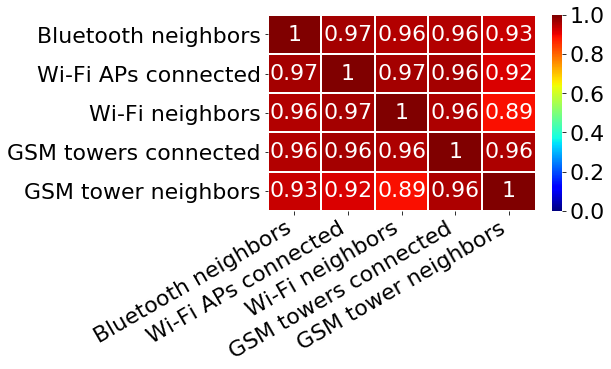

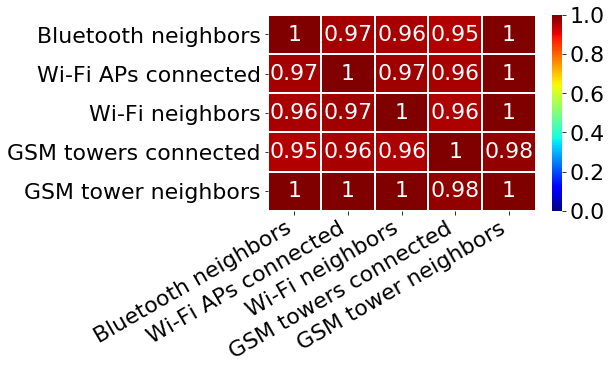

In [170]:
#total_proximity = pd.concat(total_proximity).groupby(total_proximity.index).mean()
#total_proximity = pd.concat(total_proximity).groupby(level=0).mean()
#total_non_proximity = pd.concat(total_non_proximity).groupby(level=0).mean()

def symmetric_matrix(result, ground_truths):
    output = collections.defaultdict(dict)
    for g1, g2 in itertools.product(ground_truths, repeat=2):
        correlation = np.mean(result[g1][g2])
        if np.isnan(correlation):
            correlation = np.mean(result[g2][g1])
        output[g1][g2] = correlation    
    df = pd.DataFrame.from_dict(output)
    df = df.reindex(index=df.columns)
    np.fill_diagonal(df.values, 1)
    return df

avg_proximity = symmetric_matrix(proximity, ground_truths)
heatmap(relabel(avg_proximity), "proximity")
avg_non_proximity = symmetric_matrix(non_proximity, ground_truths)
heatmap(relabel(avg_non_proximity), "non-proximity")

In [168]:
pd.Series(found_ground_truth).value_counts()

[gsm]                                                206
[bluetooth, gsm, sensor_wifi, wifi]                  138
[gsm, wifi]                                          110
[gsm, sensor_wifi, wifi]                              67
[bluetooth, gsm, wifi]                                33
[wifi]                                                29
[bluetooth, sensor_wifi, wifi]                        21
[sensor_wifi, wifi]                                   17
[gsm, sensor_wifi]                                    14
[sensor_wifi]                                          5
[gsm, gsm_neighbor]                                    4
[bluetooth, gsm]                                       4
[gsm_neighbor]                                         4
[bluetooth, wifi]                                      3
[bluetooth, gsm, sensor_wifi]                          2
[gsm_neighbor, wifi]                                   1
[bluetooth, gsm, gsm_neighbor, sensor_wifi, wifi]      1
[bluetooth, sensor_wifi]       

# Proximity Reasoning

In [177]:
timedelta_evaluation = pd.Timedelta("120min")

ground_truths = {
                 "bluetooth": "bt_address",
                 "sensor_wifi": "bssid",
                 "wifi": "bssid",
                 "gsm": "cid",
                 "gsm_neighbor": "cid"
} # "locations" only lat, long take range as distance threshold between users to infer in proximity

sensor_data_fields = {
                      "magnetometer": ["double_values_0", "double_values_1", "double_values_2"],
                      "accelerometer": ["double_values_0", "double_values_1", "double_values_2"],
                      "barometer": ["double_values_0"],
                      #"light": ["double_light_lux"],
                      #"gravity": ["double_values_0", "double_values_1", "double_values_2"],
                      #"gyroscope": ["double_values_0", "double_values_1", "double_values_2"],
                      #"linear_accelerometer": ["double_values_0", "double_values_1", "double_values_2"],
                      #"rotation": ["double_values_0", "double_values_1", "double_values_2"]
}

def get_all_keys(data, level=None, sep=";"):
    
    def __to_num(s):
        try:
            return int(s)
        except ValueError:
            try:
                return float(s)
            except ValueError:
                return s
    
    def __flatten(data, sep, parent_key=''):
        items = []
        for k, v in data.items():
            new_key = parent_key + sep + str(k) if parent_key else str(k)
            if isinstance(v, collections.MutableMapping):
                items.extend(__flatten(v, sep, new_key).items())
            else:
                items.append((new_key, v))
        return dict(items)
    
    unique_keys = list()
    keys = list(__flatten(data, sep).keys())
    levels = keys[0].count(sep) + 1 if level == None else level
    for level in range(levels):
        subset = set([key.split(sep)[level] for key in keys])
        subset = sorted(map(__to_num, subset))
        unique_keys.append(subset)
    return unique_keys

def device_heterogeneity(proximity_groups, sensor_type):
    
    def adapt_apple_name(x):
        regex_result = regex.match(x)
        if regex_result:
            return regex_result.group(1)
        return np.nan
    
    # add sensor details
    result = proximity_groups.merge(clean_sensor_hardware[sensor_type], on="device_id", how="left")
    
    # add device model and product
    result = result.merge(df_data["aware_device"], on="device_id")
    
    # add sensor name via model
    result["model"] = result["model"].str.upper()
    result = result.merge(mapping_device_model_to_sensor[sensor_type], on="model", how="left")
    # Join sensor names from direct hardware table or via model > sensor
    result["sensor_name"] = result["sensor_name_x"].fillna(result["sensor_name_y"])
    
    regex = re.compile("(iPhone [a-zA-Z]*\d*).*")
    result["product"] = result["product"].apply(adapt_apple_name)
    
    # fillna: sensor_name with product (Apple) and then with model (Android)
    result["sensor_name"] = result["sensor_name"].fillna(result["product"]).fillna(result.model)
    
    return result

## Preprocessing

In [ ]:
print("sort")
for data_identifier in list(ground_truths.keys()) + list(sensor_data_fields.keys()):
    if data_identifier in df_data:
        print(data_identifier)
        df_data[data_identifier] = df_data[data_identifier].sort_values(by=["timestamp"])

In [179]:
clean_sensor_hardware = {}
for name, data in df_hardware.items():
    data.sensor_name = clean_sensor_names(data.sensor_name)
    clean_sensor_hardware[name] = data
print("clean sensor hardware", clean_sensor_hardware.keys())

clean sensor hardware dict_keys(['accelerometer', 'barometer', 'magnetometer'])


In [192]:
mapping_device_model_to_sensor = {}
for sensor in df_hardware:
    device_model_to_sensor = clean_sensor_hardware[sensor].merge(
        df_data["aware_device"], left_on="device_id", right_on="device_id")
    device_model_to_sensor = device_model_to_sensor.drop_duplicates(subset=["model"])
    device_model_to_sensor.replace('', np.nan, inplace=True)
    device_model_to_sensor = device_model_to_sensor.dropna(subset=["sensor_name"])
    device_model_to_sensor["model"] = device_model_to_sensor["model"].str.upper()
    mapping_device_model_to_sensor[sensor] = device_model_to_sensor[["model", "sensor_name"]]
    print(sensor)
    print(mapping_device_model_to_sensor[sensor])

accelerometer
             model sensor_name
0         NEXUS 5X      BMI160
1            PIXEL      BMI160
2        SM-G532MT      BMA254
4    ONEPLUS A5000      BMI160
5    ONEPLUS A3003     LSM6DS3
8           XT1650      BMI160
10         PIXEL 2     LSM6DSM
11           D6683      BMA2X2
12           MI 5S      BMI160
13        SM-G930F     K6DS3TR
14        PIXEL XL      BMI160
15           D6603      BMA2X2
17             FP2     LSM330D
18       SM-J510FN        K2HH
19        SM-N950F     LSM6DSL
20           A0001      LIS3DH
21       SM-A500FU      BMC150
23         LG-H815         LGE
24  HUAWEI GRA-L09      LSM330
27           E6653  INVENSENSE
29       SM-A320FL     K6DS3TR
30        SM-A510F       BOSCH
33           MI A1      BMI120
35       SM-A300FU      BMC150
36        SM-G950F     LSM6DSL
37         SM-P580        K2HH
40        SM-G935F     K6DS3TR
41        SM-A310F       BOSCH
43      PIXEL 2 XL     LSM6DSM
46           E5823  INVENSENSE
49        GT-I9515       

## Find best encounter times

In [ ]:
# To improve the runtime, we can search after the best week and then find the best encounter time
# Search after a time of maximum amount of devices, but could be they have not enough data

In [47]:
def proximity_count(proximity_groups, non_proximity_devices, sensor_data, sensor_data_columns):
    
    def compare(device1, device2):
        if len(sensor_data) > 0:
            sensor_data_column = sensor_data_columns[0]
            data_device1 = sensor_data[sensor_data.device_id == device1][sensor_data_column].dropna()
            data_device2 = sensor_data[sensor_data.device_id == device2][sensor_data_column].dropna()
            if len(data_device1) > 0 and len(data_device2) > 0:
                return len(data_device1) + len(data_device2)
        return 0
    
    length_sensor_data_proximity = []
    length_sensor_data_non_proximity = []
    for proximity_group in proximity_groups:
        for device1, device2 in itertools.combinations(proximity_group, 2):
            length_sensor_data_proximity.append(compare(device1, device2))    
        for proximity_device in proximity_group:
            for device1, device2 in zip(len(non_proximity_devices)*[proximity_device], non_proximity_devices):
                length_sensor_data_non_proximity.append(compare(device1, device2))
    
    devices_proximity = len([entry for entry in length_sensor_data_proximity if entry != 0])
    devices_non_proximity = len([entry for entry in length_sensor_data_non_proximity if entry != 0])
    return devices_proximity, devices_non_proximity, sum(length_sensor_data_proximity), sum(length_sensor_data_non_proximity)
    
def time_range_evaluation(ground_truths, df_data, ground_truth, sensor_type, user_entropy, user_group, timedelta, result_path):
    proximity_encounters = nested_dict(4, dict)
    group_field = ground_truths[ground_truth]
    end_time_condition = min(df_data[sensor_type].timestamp.iloc[-1], df_data[ground_truth].timestamp.iloc[-1])
    start_time_window = max(df_data[sensor_type].timestamp.iloc[0], df_data[ground_truth].timestamp.iloc[0])
    end_time_window = start_time_window + timedelta
    
    ground_truth_data = df_data[ground_truth]
    if user_group is not None:
        ground_truth_data = df_data[ground_truth][df_data[ground_truth].device_id.isin(user_group)]
    
    while start_time_window < end_time_condition:
        ground_truth_selection = ground_truth_data[(ground_truth_data.timestamp >= start_time_window) & (ground_truth_data.timestamp < end_time_window)]
        device_groups = ground_truth_selection.groupby(group_field).device_id.unique()
        
        if len(device_groups) > 0:
            temp_proximity_groups = device_groups[device_groups.str.len() > 1]
            if len(temp_proximity_groups) > 0:
                proximity_groups = []
                for proximity_group in temp_proximity_groups:
                    if True not in [np.array_equal(np.sort(proximity_group), np.sort(device_group)) for device_group in proximity_groups]:
                        proximity_groups.append(proximity_group.tolist())
                non_proximity_devices = np.setdiff1d(ground_truth_selection.device_id, np.concatenate(temp_proximity_groups.values))

                if len(non_proximity_devices) > 1:
                    sensor_data = df_data[sensor_type][(df_data[sensor_type].timestamp >= start_time_window) & (df_data[sensor_type].timestamp < end_time_window)]
                    
                    num_devices_proximity, num_devices_non_proximity, \
                        length_sensor_data_proximity, length_sensor_data_non_proximity = proximity_count(
                            proximity_groups, non_proximity_devices, sensor_data, sensor_data_fields[sensor_type])
                    
                    if num_devices_proximity > 0 and num_devices_non_proximity > 0:
                        test_time = DateTimeRangeHashable(start_time_window, end_time_window)
                        print("### found groups with mixed hardware")
                        proximity_encounters[ground_truth][sensor_type]["mixed"][user_entropy][test_time] = (num_devices_proximity, num_devices_non_proximity, length_sensor_data_proximity, length_sensor_data_non_proximity)
                        
                        group_assignment = [[i]*size for i, size in enumerate(map(len, proximity_groups))]
                        proximity_groups = pd.DataFrame({"group": list(itertools.chain(*group_assignment)),
                                                        "device_id": list(itertools.chain(*proximity_groups))})
                        proximity_groups = device_heterogeneity(proximity_groups, sensor_type)
                        # Group by sensor name which can be actual sensor name, model (Android) or product (iPhone)
                        proximity_groups = proximity_groups.groupby(["group", "sensor_name"]).device_id.unique()
                        if len(proximity_groups) > 0:
                            temp_proximity_groups = proximity_groups[proximity_groups.str.len() > 1]
                            if len(temp_proximity_groups) > 0:
                                proximity_groups = []
                                for proximity_group in temp_proximity_groups:
                                    if True not in [np.array_equal(np.sort(proximity_group), np.sort(device_group)) for device_group in proximity_groups]:
                                        proximity_groups.append(proximity_group.tolist())
                                num_devices_proximity, num_devices_non_proximity, \
                                    length_sensor_data_proximity, length_sensor_data_non_proximity = proximity_count(
                                        proximity_groups, non_proximity_devices, sensor_data, sensor_data_fields[sensor_type])
                                if num_devices_proximity > 0 and num_devices_non_proximity > 0:
                                    print("### found groups with same hardware")
                                    proximity_encounters[ground_truth][sensor_type]["same"][user_entropy][test_time] = (num_devices_proximity, num_devices_non_proximity, length_sensor_data_proximity, length_sensor_data_non_proximity)
                                    
        start_time_window = end_time_window
        end_time_window += timedelta
    
    # save result
    if len(proximity_encounters) > 0:
        path = os.path.join(result_path, "proximity-encounters-" + str(os.getpid()))
        DillSerializer(path).serialize(proximity_encounters)

proc = []
for ground_truth in ground_truths:
    for sensor_type in sensor_data_fields:
        for user_entropy, user_group in user_groups.items():
            print("Ground truth", ground_truth)
            print("Sensor data", sensor_type)
            print("User group", user_entropy)
            p = Process(target=time_range_evaluation,
                        args=[ground_truths, df_data, ground_truth,
                              sensor_type, user_entropy, user_group, timedelta_evaluation, result_path])
            p.start()
            proc.append(p)
            
# wait for processes to finish
for p in proc:
    p.join()

Ground truth bluetooth
Sensor data barometer
User group 3.0521033538995677
Ground truth bluetooth
Sensor data barometer
User group 1.8604785209730075
### found groups with mixed hardware
Ground truth bluetooth
Sensor data barometer
User group 2.1553135311816405
### found groups with mixed hardware
Ground truth sensor_wifi
Sensor data barometer
User group 3.0521033538995677
### found groups with mixed hardware
Ground truth sensor_wifi
Sensor data barometer
User group 1.8604785209730075
### found groups with mixed hardware
### found groups with mixed hardware
Ground truth sensor_wifi
Sensor data barometer
User group 2.1553135311816405
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
Ground truth wifi
Sensor data barometer
User group 3.0521033538995677
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed har

### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### fou

### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found

### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### fou

### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found 

### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found

### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### foun

### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found g

### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found

### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### f

### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### fo

### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### fou

### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found

### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### fo

### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found g

### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found

### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### foun

### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware
### found groups with same hardware
### found groups with mixed hardware


In [150]:
proximity_encounters = [DillSerializer(fpath).deserialize() for fpath in glob.glob(os.path.join(result_path, "encounters", "*"))]

In [151]:
encounter_summary = collections.defaultdict(dict)
for proximity_encounter in proximity_encounters:
    eval_ground_truths, eval_sensor_types, eval_sensor_hardwares, eval_user_entropies, _ = get_all_keys(proximity_encounter)
    for ground_truth, sensor_type, sensor_hardware, user_entropy in itertools.product(
            eval_ground_truths, eval_sensor_types, eval_sensor_hardwares, eval_user_entropies):
        results = proximity_encounter[ground_truth][sensor_type][sensor_hardware][user_entropy]
        weekday = []
        start_time = []
        end_time = []
        sensor_data = []
        for time_range in results:
            proximity, non_proximity = results[time_range]
            sensor_data.append(proximity)
            start_time.append(time_range.start_datetime)
            end_time.append(time_range.end_datetime)
            weekday.append(time_range.end_datetime.weekday())
        df = pd.DataFrame({"weekday": weekday, "start": start_time, "end": end_time, "proximity": sensor_data})
        df = df.sort_values(by=["start"])
        df = series_to_df(df.groupby(["weekday", df.start.dt.hour]).sum())
        if df.weekday.unique().size == 7:
            encounter_summary[sensor_type][df.proximity.sum()] = df

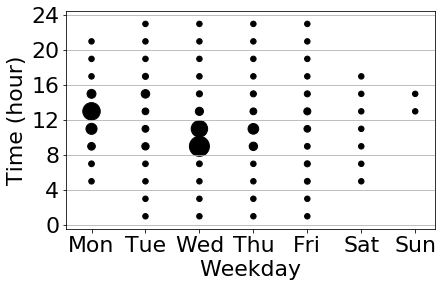

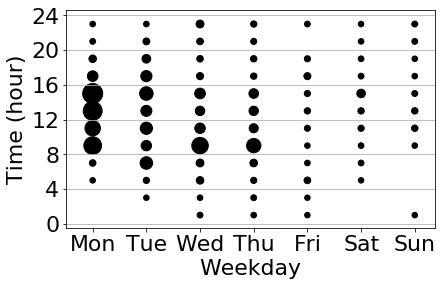

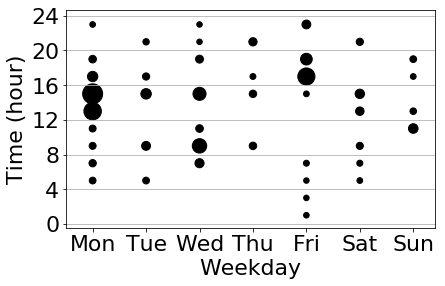

In [152]:
def plot(sensor, df):
    fig, ax = plt.subplots()
    ax.set_xticks(df.weekday.unique())
    ax.set_xticklabels(calendar.day_abbr)
    ax.yaxis.grid()
    ax.set_yticks(range(0, 25, 4))
    ax.set_ylabel("Time (hour)")
    ax.set_xlabel("Weekday")
    scaler = scale_marker(df.proximity.values, (30, 400))
    size = scaler.transform(df.proximity.values.reshape(-1, 1))
    ax.scatter(df.weekday, df.start, size, color=default_color)
    fig.set_figwidth(fig.get_figwidth()*1.1)
    fig.savefig(get_plot_path("proximity-encounters-" + sensor), format=plot_format, bbox_inches="tight")
    
for sensor in encounter_summary:
    result = encounter_summary[sensor]
    df = sorted(result.items(), key=lambda kv: kv[0], reverse=True)
    plot(sensor, df[0][1])
    if "accelerometer" in sensor:
        plot("barometer", df[2][1])

In [153]:
def create_df(data):            
    print("parameter sets:", len(data))
    df = pd.DataFrame({"ground truth": [entry[0] for entry in data],
                       "sensor data": [entry[1] for entry in data],
                       "hardware": [entry[2] for entry in data],
                       "entropy": [entry[3] for entry in data]})
    display(df.sort_values(by=["ground truth", "sensor data", "hardware", "entropy"]))

best_evaluation_time_devices = []
best_evaluation_time_sensor_data = []

proximity_encounters = [DillSerializer(fpath).deserialize() for fpath in glob.glob(os.path.join(result_path, "encounters", "*"))]
for proximity_encounter in proximity_encounters:
    eval_ground_truths, eval_sensor_types, eval_sensor_hardwares, eval_user_entropies, _ = get_all_keys(proximity_encounter)
    for ground_truth, sensor_type, sensor_hardware, user_entropy in itertools.product(
            eval_ground_truths, eval_sensor_types, eval_sensor_hardwares, eval_user_entropies):
        
        best_time_devices = None
        max_proximity_devices = 0
        best_time_sensor_data = None
        max_proximity_sensor_data = 0
        results = proximity_encounter[ground_truth][sensor_type][sensor_hardware][user_entropy]
        if len(results[list(results.keys())[0]]) == 4:
            for test_time, (num_devices_proximity, num_devices_non_proximity, length_sensor_data_proximity, length_sensor_data_non_proximity) in results.items():
                if num_devices_proximity > max_proximity_devices and num_devices_non_proximity > 0.2*num_devices_proximity:
                    max_proximity_devices = num_devices_proximity
                    best_time_devices = test_time
                if length_sensor_data_proximity > max_proximity_sensor_data and length_sensor_data_non_proximity > 0.2*length_sensor_data_proximity:
                    max_proximity_sensor_data = length_sensor_data_proximity
                    best_time_sensor_data = test_time
        else:
            for test_time, (length_sensor_data_proximity, length_sensor_data_non_proximity) in results.items():
                if length_sensor_data_proximity > max_proximity_sensor_data and length_sensor_data_non_proximity > 0.2*length_sensor_data_proximity:
                    max_proximity_sensor_data = length_sensor_data_proximity
                    best_time_sensor_data = test_time
        
        # sensor data more important than only counting the number of proximity devices
        if best_time_devices != None:
            best_evaluation_time_devices.append((ground_truth, sensor_type, sensor_hardware, user_entropy, best_time_devices))
        
        if best_time_sensor_data != None:
            best_evaluation_time_sensor_data.append((ground_truth, sensor_type, sensor_hardware, user_entropy, best_time_sensor_data))
        
        if len(results[list(results.keys())[0]]) == 4:        
            if max_proximity_devices == 0 or max_proximity_sensor_data == 0:
                print("### Missing data")
                print("devices", max_proximity_devices)
                print("sensor data", max_proximity_sensor_data)
                print(ground_truth)
                print(sensor_type)
                print(sensor_hardware)
                print(user_entropy)
        else:
            if max_proximity_sensor_data == 0:
                print("### Missing data")
                print("sensor data", max_proximity_sensor_data)
                print(ground_truth)
                print(sensor_type)
                print(sensor_hardware)
                print(user_entropy)

#create_df(best_evaluation_time_devices)
create_df(best_evaluation_time_sensor_data)

parameter sets: 55


,ground truth,sensor data,hardware,entropy
41,bluetooth,accelerometer,mixed,1.853970
26,bluetooth,accelerometer,mixed,2.157084
51,bluetooth,accelerometer,mixed,3.030052
42,bluetooth,accelerometer,same,1.853970
27,bluetooth,accelerometer,same,2.157084
52,bluetooth,accelerometer,same,3.030052
53,bluetooth,magnetometer,mixed,1.853970
43,bluetooth,magnetometer,mixed,2.157084
23,bluetooth,magnetometer,mixed,3.030052
54,bluetooth,magnetometer,same,1.853970


## Proximity detection

In [78]:
def proximity_distance(proximity_groups, non_proximity_devices, sensor_data, sensor_data_fields):
    
    def filter_list(seq):
        if len(seq) > 0:
            return [x for x in seq if x is not None]
        return []
    
    def compare(device1, device2):
        if len(sensor_data) > 0:
            data_device1 = sensor_data[sensor_data.device_id == device1]
            data_device2 = sensor_data[sensor_data.device_id == device2]
            if len(data_device1) > 0 and len(data_device2) > 0:
                dist_data_field = []
                for data_field in sensor_data_fields:
                    dev1 = data_device1[data_field].values
                    dev2 = data_device2[data_field].values
                    dist = dtw.distance_fast(dev1, dev2)
                    dist_data_field.append(dist)
                return np.mean(dist_data_field)
    
    dist_proximity = []
    dist_non_proximity = []
    for proximity_group in proximity_groups:
        for device1, device2 in itertools.combinations(proximity_group, 2):
            dist_proximity.append(compare(device1, device2))    
        for proximity_device in proximity_group:
            for device1, device2 in zip(len(non_proximity_devices)*[proximity_device], non_proximity_devices):
                dist_non_proximity.append(compare(device1, device2))
    
    dist_proximity = filter_list(dist_proximity)
    dist_non_proximity = filter_list(dist_non_proximity)
    if len(dist_proximity) > 0 and len(dist_non_proximity) > 0:
        # take median to compensate larger amount of non-proximity devices
        return np.mean(dist_proximity), np.median(dist_non_proximity)
    return None, None

def perform_proximity_testing(
        hardware_mode, ground_truth, group_field, sensor_data, sensor_data_fields, sensor_type, time_window):
    
    total_dist_proximity = []
    total_dist_non_proximity = []
    group_size_proximity = []
    group_size_non_proximity = []
    
    timedelta = pd.Timedelta("{}min".format(time_window))
    start_time_window = ground_truth.timestamp.iloc[0]
    end_time_condition = ground_truth.timestamp.iloc[-1]
    end_time_window = start_time_window + timedelta
    
    while start_time_window < end_time_condition:
        ground_truth_data = ground_truth[(ground_truth.timestamp >= start_time_window) & (ground_truth.timestamp < end_time_window)]    
        device_groups = ground_truth_data.groupby(group_field).device_id.unique()
        
        if len(device_groups) > 0:
            temp_proximity_groups = device_groups[device_groups.str.len() > 1]
            if len(temp_proximity_groups) > 0:
                proximity_groups = []
                for proximity_group in temp_proximity_groups:
                    if True not in [np.array_equal(np.sort(proximity_group), np.sort(device_group)) for device_group in proximity_groups]:
                        proximity_groups.append(proximity_group.tolist())
                non_proximity_devices = np.setdiff1d(ground_truth_data.device_id, np.concatenate(temp_proximity_groups.values))
                
                if len(non_proximity_devices) > 1:
                    sensor_data_selection = sensor_data[(sensor_data.timestamp >= start_time_window) & (sensor_data.timestamp < end_time_window)]
                    dist_proximity, dist_non_proximity = proximity_distance(
                        proximity_groups, non_proximity_devices, sensor_data_selection, sensor_data_fields)
                    
                    if dist_proximity != None and dist_non_proximity != None:
                        test_time = DateTimeRangeHashable(start_time_window, end_time_window)
                        if "mixed" in hardware_mode:
                            total_dist_proximity.append(dist_proximity)
                            total_dist_non_proximity.append(dist_non_proximity)
                            group_size_proximity.extend(list(map(len, proximity_groups)))
                            group_size_non_proximity.append(len(non_proximity_devices))
                        elif "same" in hardware_mode:
                            group_assignment = [[i]*size for i, size in enumerate(map(len, proximity_groups))]
                            proximity_groups = pd.DataFrame({"group": list(itertools.chain(*group_assignment)),
                                                            "device_id": list(itertools.chain(*proximity_groups))})
                            proximity_groups = device_heterogeneity(proximity_groups, sensor_type)
                            proximity_groups = proximity_groups.groupby(["group", "sensor_name"]).device_id.unique()
                            
                            if len(proximity_groups) > 0:
                                temp_proximity_groups = proximity_groups[proximity_groups.str.len() > 1]
                                if len(temp_proximity_groups) > 0:
                                    proximity_groups = []
                                    for proximity_group in temp_proximity_groups:
                                        if True not in [np.array_equal(np.sort(proximity_group), np.sort(device_group)) for device_group in proximity_groups]:
                                            proximity_groups.append(proximity_group.tolist())
                                    dist_proximity, dist_non_proximity = proximity_distance(
                                        proximity_groups, non_proximity_devices, sensor_data_selection, sensor_data_fields)
                                    if dist_proximity != None and dist_non_proximity != None:
                                        total_dist_proximity.append(dist_proximity)
                                        total_dist_non_proximity.append(dist_non_proximity)
                                        group_size_proximity.extend(list(map(len, proximity_groups)))
                                        group_size_non_proximity.append(len(non_proximity_devices))
        
        start_time_window = end_time_window
        end_time_window += timedelta
    
    return np.mean(total_dist_proximity), np.mean(total_dist_non_proximity), \
        np.mean(group_size_proximity), np.mean(group_size_non_proximity)

In [ ]:
def run(time_range, ground_truths, ground_truth, df_data, sensor_data_fields, sensor_type, hardware_mode, user_groups, user_entropy):
    proximity_result = pd.DataFrame(columns=["Hardware", "Ground truth", "Sensor data", "User entropy", "Time window",
                                         "Proximity", "Non-Proximity", "Ratio", "Size proximity", "Size non-proximity"])
    minidx = np.argmin([abs(x-user_entropy) for x in user_groups])
    nearest_user_entropy = list(user_groups.keys())[minidx]
    user_group = user_groups[nearest_user_entropy]
    group_field = ground_truths[ground_truth]
    start_range =  pd.to_datetime(time_range.start_datetime)
    stop_range =  pd.to_datetime(time_range.end_datetime)    
    ground_truth_selection = df_data[ground_truth][(df_data[ground_truth].timestamp >= start_range) & (df_data[ground_truth].timestamp <= stop_range)]    
    if user_group is not None:
        ground_truth_selection = ground_truth_selection[ground_truth_selection.device_id.isin(user_group)]
    sensor_data_selection = df_data[sensor_type][(df_data[sensor_type].timestamp >= start_range) & (df_data[sensor_type].timestamp <= stop_range)]
    
    for time_minutes in range(5, 35, 5):        
        dist_proximity, dist_non_proximity, group_size_proximity, group_size_non_proximity = \
            perform_proximity_testing(
                hardware_mode, ground_truth_selection, group_field,
                sensor_data_selection, sensor_data_fields[sensor_type], sensor_type, time_minutes)
        ratio = dist_non_proximity / dist_proximity
        print("ground truth:", ground_truth)
        print("sensor data:", sensor_type)
        print("hardware:", hardware_mode)
        print("user entropy", user_entropy)
        print("time window:", time_minutes)
        print("proximity", dist_proximity)
        print("non-proximity", dist_non_proximity)
        print("ratio", ratio)
        proximity_result.loc[len(proximity_result)] = [hardware_mode, ground_truth, sensor_type, nearest_user_entropy, time_minutes,
                                                       dist_proximity, dist_non_proximity, ratio, group_size_proximity, group_size_non_proximity]
    
    path = os.path.join(result_path, "proximity-result-" + str(os.getpid()))
    DillSerializer(path).serialize(proximity_result)
    
proc = []
for ground_truth, sensor_type, hardware_mode, user_entropy, time_range in best_evaluation_time_sensor_data:
    p = Process(target=run,
                args=[time_range, ground_truths, ground_truth, df_data,
                      sensor_data_fields, sensor_type, hardware_mode,
                      user_groups, user_entropy])
    p.start()
    proc.append(p)

# wait for processes to finish
for p in proc:
    p.join()

ground truth: sensor_wifi


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sensor data: magnetometer
sensor data: magnetometer
user entropy 1.8539704656077882
non-proximity 2397.9272471754857
time window: 5
ratio 0.5517762104753564
ratio nan
ground truth: wifi
user entropy 2.1570842463525484
non-proximity 4.48713218403594


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


sensor data: barometer
hardware: mixed
sensor data: magnetometer
proximity 12.379172354165618
ground truth: wifi
time window: 5
ratio nan
user entropy 2.1570842463525484
time window: 10


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hardware: mixed
proximity nan
hardware: same
hardware: mixed
user entropy 3.0300519348974593
user entropy 3.0300519348974593
non-proximity nan
sensor data: magnetometer
non-proximity nan
non-proximity nan
proximity nan
time window: 15
sensor data: barometer
sensor data: barometer
ground truth: bluetooth
time window: 15
time window: 20
proximity 24.637393524739775
proximity nan
non-proximity 62.74215223044151
sensor data: magnetometer


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hardware: mixed
ground truth: sensor_wifi
proximity nan


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


user entropy 3.0300519348974593
hardware: same
sensor data: magnetometer
ground truth: bluetooth
non-proximity nan
hardware: same
hardware: same
sensor data: magnetometer
user entropy 2.1570842463525484
sensor data: accelerometer
non-proximity 9.667897554301577
proximity 2106.785531391347
proximity nan
time window: 30
ground truth: wifi
non-proximity 12514.963242244434
sensor data: barometer
ratio nan
time window: 5
non-proximity 27.240550458484897
user entropy 3.0300519348974593
ground truth: sensor_wifi
ground truth: wifi
hardware: mixed


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


sensor data: magnetometer
user entropy 2.1570842463525484


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


time window: 15
user entropy 3.0300519348974593
proximity nan
hardware: mixed
non-proximity 63.877077945989676
time window: 5
user entropy 2.1570842463525484
ratio nan
time window: 5
ratio 15.623493595772953
ground truth: wifi
sensor data: barometer
ground truth: gsm
user entropy 3.0300519348974593
sensor data: magnetometer
user entropy 1.8539704656077882
time window: 10
non-proximity nan
user entropy 3.0300519348974593
time window: 10
time window: 5
proximity 24.637393524739775
sensor data: magnetometer
sensor data: magnetometer
ground truth: gsm
ground truth: sensor_wifi
hardware: same
ratio 14.713781231039174
sensor data: magnetometer
hardware: mixed
user entropy 3.0300519348974593
user entropy 3.0300519348974593
hardware: same
sensor data: barometer
ratio nan
ratio 1.6174509352733097
proximity nan
proximity 2525.1848504068203
user entropy 3.0300519348974593
non-proximity 2077.3057602697554
hardware: same
ratio 0.8226351270621202
non-proximity nan
user entropy 3.0300519348974593
har

/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


sensor data: barometer
hardware: mixed
ground truth: bluetooth
sensor data: accelerometer
ground truth: wifi
user entropy 1.8539704656077882


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hardware: mixed
time window: 25
sensor data: barometer
ground truth: gsm
user entropy 3.0300519348974593
proximity 25.268546825088126
sensor data: magnetometer
non-proximity 66.34055311169762
hardware: mixed
time window: 5
ratio 2.6254201941613333
user entropy 2.1570842463525484
proximity nan
hardware: same
time window: 25
user entropy 2.1570842463525484
proximity 25.268546825088126
non-proximity nan
time window: 5
proximity nan
non-proximity 107.03996524993119
ratio 4.236095015311902
ratio nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: mixed
user entropy 3.0300519348974593
time window: 10
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: mixed
user entropy 3.0300519348974593
time window: 15
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: mixed
user entropy 3.0300519348974593
time window: 20
proximity nan
non-proximity nan
ratio nan
g

/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ground truth: wifi
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 5
proximity nan
non-proximity nan
ratio nan


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ground truth: bluetooth
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 5
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 10
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 15
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 20
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 25
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 30
proximity nan
non-proximity nan
ratio nan


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ground truth: bluetooth
sensor data: magnetometer
hardware: same
user entropy 1.8539704656077882
time window: 5
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: magnetometer
hardware: same
user entropy 1.8539704656077882
time window: 10
proximity nan
non-proximity nan
ratio nan
ground truth: wifi
sensor data: barometer
hardware: mixed
user entropy 1.8539704656077882
time window: 30
proximity 24.009596914774562
non-proximity 68.50401642733499
ratio 2.853193107343685
ground truth: gsm
sensor data: magnetometer
hardware: mixed
user entropy 3.0300519348974593
time window: 15
proximity 772.4514873036906
non-proximity 2181.807012910558
ratio 2.8245230267163395
ground truth: bluetooth
sensor data: magnetometer
hardware: mixed
user entropy 1.8539704656077882
time window: 5
proximity 2457.90745619951
non-proximity 891.9946295145227
ratio 0.36290814256031895
ground truth: gsm
sensor data: magnetometer
hardware: same
user entropy 3.0300519348974593
time window: 30
pr

/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ground truth: bluetooth
sensor data: accelerometer
hardware: mixed
user entropy 1.8539704656077882
time window: 5
proximity nan
non-proximity nan
ratio nan


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ground truth: bluetooth
sensor data: accelerometer
hardware: same
user entropy 1.8539704656077882
time window: 5
proximity nan
non-proximity nan
ratio nan
ground truth: wifi
sensor data: magnetometer
hardware: same
user entropy 1.8539704656077882
time window: 15
proximity 5292.771427190312
non-proximity 20272.463752515418
ratio 3.830217123749312
ground truth: bluetooth
sensor data: magnetometer
hardware: same
user entropy 1.8539704656077882
time window: 30
proximity 7380.562948686699
non-proximity 3675.624775779246
ratio 0.49801414896587104
ground truth: bluetooth
sensor data: magnetometer
hardware: mixed
user entropy 1.8539704656077882
time window: 20
proximity 3414.5862029596783
non-proximity 1150.0189771601458
ratio 0.3367960006876786
ground truth: sensor_wifi
sensor data: magnetometer
hardware: mixed
user entropy 1.8539704656077882
time window: 15
proximity 5650.680032863656
non-proximity 5038.64571700079
ratio 0.8916883786901133
ground truth: sensor_wifi
sensor data: magnetometer


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


hardware: mixed


/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


user entropy 1.8539704656077882
time window: 25
ground truth: wifi
proximity 2411.2416649187426
non-proximity 1286.2705235530316
sensor data: accelerometer
ratio 0.5334473695718832
hardware: same
user entropy 1.8539704656077882
time window: 5
proximity nan
non-proximity nan
ratio nan
ground truth: sensor_wifi
sensor data: accelerometer
hardware: mixed
user entropy 3.0300519348974593
time window: 15
proximity nan
non-proximity nan
ratio nan
ground truth: sensor_wifi
sensor data: magnetometer
hardware: mixed
user entropy 2.1570842463525484
time window: 10
proximity 4456.41616684266
non-proximity 2600.7875318625975
ratio 0.5836051738644593
ground truth: gsm
sensor data: magnetometer
hardware: same
user entropy 2.1570842463525484
time window: 10
proximity nan
non-proximity nan
ratio nan
ground truth: gsm_neighbor
sensor data: magnetometer
hardware: mixed
user entropy 2.1570842463525484
time window: 5
proximity 2241.94806614058
non-proximity 2229.9451188435582
ratio 0.9946461974394953
groun

/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/haus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ground truth: wifi
sensor data: accelerometer
hardware: mixed
user entropy 3.0300519348974593
time window: 5
proximity nan
non-proximity nan
ratio nan
ground truth: gsm_neighbor
sensor data: magnetometer
hardware: same
user entropy 2.1570842463525484
time window: 5
proximity 1474.4518451809533
non-proximity 3293.908618011006
ratio 2.233988603138652
ground truth: wifi
sensor data: magnetometer
hardware: mixed
user entropy 2.1570842463525484
time window: 5
proximity 5398.632309914676
non-proximity 3657.6115493207167
ratio 0.6775070683371887
ground truth: gsm
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 20
proximity nan
non-proximity nan
ratio nan
ground truth: gsm
sensor data: magnetometer
hardware: same
user entropy 1.8539704656077882
time window: 10
proximity 23817.57317996593
non-proximity 6229.142076375627
ratio 0.2615355489540491
ground truth: wifi
sensor data: magnetometer
hardware: same
user entropy 2.1570842463525484
time window: 5
proxim

non-proximity 4536.005489751993
ratio 2.43580083591885
ground truth: wifi
sensor data: accelerometer
hardware: mixed
user entropy 1.8539704656077882
time window: 5
proximity 1050.0091573823615
non-proximity 471.672286732511
ratio 0.4492077839667366
ground truth: sensor_wifi
sensor data: magnetometer
hardware: same
user entropy 2.1570842463525484
time window: 20
proximity 6064.381582245197
non-proximity 3327.1053520956725
ratio 0.5486306075851989
ground truth: wifi
sensor data: accelerometer
hardware: same
user entropy 3.0300519348974593
time window: 30
proximity nan
non-proximity nan
ratio nan
ground truth: bluetooth
sensor data: magnetometer
hardware: same
user entropy 2.1570842463525484
time window: 15
proximity 9173.48208554382
non-proximity 4238.985091450691
ratio 0.4620911723510927
ground truth: wifi
sensor data: magnetometer
hardware: same
user entropy 1.8539704656077882
time window: 30
proximity 4320.129138506164
non-proximity 28337.883442059006
ratio 6.559499156976086
ground tr

sensor data: accelerometer
hardware: mixed
user entropy 1.8539704656077882
time window: 10
proximity 1482.2392206496158
non-proximity 717.5557130047761
ratio 0.4841025004656775
ground truth: wifi
sensor data: magnetometer
hardware: mixed
user entropy 1.8539704656077882
time window: 20
proximity 8389.365526509859
non-proximity 7987.632759414726
ratio 0.9521140465478966
ground truth: wifi
sensor data: accelerometer
hardware: same
user entropy 1.8539704656077882
time window: 15
proximity 1546.629777828055
non-proximity 2265.032636220944
ratio 1.4644956851934843
ground truth: gsm_neighbor
sensor data: accelerometer
hardware: same
user entropy 1.8539704656077882
time window: 10
proximity 2974.5211686414204
non-proximity 576.052389871761
ratio 0.1936622256868545
ground truth: sensor_wifi
sensor data: accelerometer
hardware: same
user entropy 1.8539704656077882
time window: 10
proximity 917.6667709666073
non-proximity 693.4104034509819
ratio 0.7556233105406998
ground truth: gsm_neighbor
senso

ratio 0.32565572408253046
ground truth: gsm
sensor data: accelerometer
hardware: same
user entropy 2.1570842463525484
time window: 5
proximity 379.99436160648264
non-proximity 564.230951584727
ratio 1.4848403255231388
ground truth: gsm_neighbor
sensor data: magnetometer
hardware: same
user entropy 1.8539704656077882
time window: 30
proximity 2906.295271452618
non-proximity 9353.773768344854
ratio 3.2184526672920164
ground truth: gsm_neighbor
sensor data: accelerometer
hardware: same
user entropy 2.1570842463525484
time window: 10
proximity 964.5189824636232
non-proximity 326.46294531970847
ratio 0.3384722864508486
ground truth: wifi
sensor data: magnetometer
hardware: mixed
user entropy 2.1570842463525484
time window: 20
proximity 7333.23277306656
non-proximity 5502.084417289919
ratio 0.7502945273328744
ground truth: sensor_wifi
sensor data: accelerometer
hardware: same
user entropy 1.8539704656077882
time window: 15
proximity 917.7635759044784
non-proximity 653.8600134191411
ratio 0.7

### Result

In [154]:
proximity_results = [DillSerializer(fpath).deserialize() for fpath in glob.glob(os.path.join(result_path, "new-detection", "*"))]
for i, result in enumerate(proximity_results):
    if "Mode" in result.columns:
        print("adapt previous results")
        proximity_results[i] = result.rename(columns={"Mode": "Hardware"})
df = pd.concat(proximity_results)
df["Time window"] = df["Time window"].astype(np.float)
df = df.dropna(subset=["Ratio"])
df.head()

,Hardware,Ground truth,Sensor data,User entropy,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity
0,mixed,wifi,barometer,2.155314,5.0,12.379172,45.026866,3.637308,2.555556,23.0
1,mixed,wifi,barometer,2.155314,10.0,24.637394,62.742152,2.546623,2.918919,23.0
2,mixed,wifi,barometer,2.155314,15.0,24.514061,63.877078,2.605732,2.977778,23.0
3,mixed,wifi,barometer,2.155314,20.0,24.749414,68.607719,2.772095,2.909091,23.0
4,mixed,wifi,barometer,2.155314,25.0,25.268547,107.039965,4.236095,3.070423,24.0


In [155]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [176]:
def sensor_data(df):
    dfs = []
    for sensor, records in df.groupby("Sensor data"):
        records = records[records["Ratio"] == max(records["Ratio"])]
        dfs.append(records)
    display(pd.concat(dfs).round(1))
    
def ground_truth(df):
    dfs = []
    for ground_truth, records in df.groupby("Ground truth"):
        records = records[records["Ratio"] == max(records["Ratio"])]
        dfs.append(records)
    display(pd.concat(dfs).round(1))
    
def user_behavior(df):
    dfs_mean = []
    dfs_max_ratio = []
    dfs_filter_mean = []
    for sensor, records in df.groupby("Sensor data"):
        for _, subrecords in records.groupby("User entropy"):
            dfs_max_ratio.append(subrecords[subrecords["Ratio"] == max(subrecords["Ratio"])])
        
        user_behavior = records.groupby("User entropy").mean()
        user_behavior["Sensor data"] = sensor
        dfs_mean.append(user_behavior) 
        
        user_behavior = records[records["Ratio"] >= 1].groupby("User entropy").mean()
        user_behavior["Sensor data"] = sensor
        dfs_filter_mean.append(user_behavior) 
    
    print("mean")
    dfs_mean = pd.concat(dfs_mean)
    dfs_mean.index = np.round(dfs_mean.index, 1)
    display(dfs_mean.round(1))
    print("max ratio")
    display(pd.concat(dfs_max_ratio).round(1))
    print("mean filter")
    dfs_filter_mean = pd.concat(dfs_filter_mean)
    dfs_filter_mean.index = np.round(dfs_filter_mean.index, 1)
    display(dfs_filter_mean.round(1))
    
def device_heterogeneity_result(df):
    dfs_mean = []
    dfs_max_ratio = []
    dfs_filter_mean = []
    for sensor, records in df.groupby("Sensor data"):
        for _, subrecords in records.groupby("Hardware"):
            dfs_max_ratio.append(subrecords[subrecords["Ratio"] == max(subrecords["Ratio"])])
        
        device_heterogeneity = records.groupby("Hardware").mean()
        device_heterogeneity["Sensor data"] = sensor
        dfs_mean.append(device_heterogeneity)
        
        device_heterogeneity = records[records["Ratio"] >=1].groupby("Hardware").mean()
        device_heterogeneity["Sensor data"] = sensor
        dfs_filter_mean.append(device_heterogeneity)
    
    print("mean")
    display(pd.concat(dfs_mean).round(1))
    print("max ratio")
    display(pd.concat(dfs_max_ratio).round(1))
    print("mean filter")
    display(pd.concat(dfs_filter_mean).round(1))
    
print("result rows: {}".format(len(df)))
print("### sensor data")
sensor_data(df)
print("### ground truth")
ground_truth(df)
print("### user behavior")
user_behavior(df)
print("### device heterogeneity")
device_heterogeneity_result(df)

result rows: 219
### sensor data


,Hardware,Ground truth,Sensor data,User entropy,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity
4,same,bluetooth,accelerometer,2.2,25.0,992.9,1888.5,1.9,2.2,5.5
5,same,wifi,barometer,1.9,30.0,0.7,13.2,18.3,2.2,17.5
5,same,wifi,barometer,2.2,30.0,0.7,13.2,18.3,2.2,22.0
5,same,wifi,magnetometer,1.9,30.0,4320.1,28337.9,6.6,2.0,25.0


### ground truth


,Hardware,Ground truth,Sensor data,User entropy,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity
4,same,bluetooth,accelerometer,2.2,25.0,992.9,1888.5,1.9,2.2,5.5
2,mixed,gsm,magnetometer,3.1,15.0,772.5,2181.8,2.8,4.0,5.0
5,same,gsm_neighbor,magnetometer,1.9,30.0,2906.3,9353.8,3.2,2.0,2.0
3,same,sensor_wifi,magnetometer,1.9,20.0,652.9,1455.8,2.2,2.0,6.0
5,same,wifi,barometer,1.9,30.0,0.7,13.2,18.3,2.2,17.5
5,same,wifi,barometer,2.2,30.0,0.7,13.2,18.3,2.2,22.0


### user behavior
mean


,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity,Sensor data
User entropy,,,,,,,
1.9,19.0,1721.3,891.3,0.7,3.1,5.4,accelerometer
2.2,17.5,1139.6,735.6,0.7,6.8,3.1,accelerometer
3.1,17.5,532.1,712.0,1.3,2.7,3.9,accelerometer
1.9,17.5,11.6,33.9,9.3,2.4,20.4,barometer
2.2,17.5,11.6,39.3,9.5,2.5,22.7,barometer
1.9,18.3,6522.8,6206.8,1.4,2.8,8.4,magnetometer
2.2,17.8,5888.7,4463.2,0.9,3.9,11.2,magnetometer
3.1,19.0,4533.1,8259.2,1.8,3.2,4.2,magnetometer


max ratio


,Hardware,Ground truth,Sensor data,User entropy,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity
2,same,bluetooth,accelerometer,1.9,15.0,728.4,1241.5,1.7,2.0,3.0
4,same,bluetooth,accelerometer,2.2,25.0,992.9,1888.5,1.9,2.2,5.5
2,mixed,gsm,accelerometer,3.1,15.0,454.4,701.4,1.5,2.7,3.9
5,same,wifi,barometer,1.9,30.0,0.7,13.2,18.3,2.2,17.5
5,same,wifi,barometer,2.2,30.0,0.7,13.2,18.3,2.2,22.0
5,same,wifi,magnetometer,1.9,30.0,4320.1,28337.9,6.6,2.0,25.0
3,same,gsm_neighbor,magnetometer,2.2,20.0,2289.6,6522.6,2.8,2.3,2.0
2,mixed,gsm,magnetometer,3.1,15.0,772.5,2181.8,2.8,4.0,5.0


mean filter


,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity,Sensor data
User entropy,,,,,,,
1.9,19.2,903.1,1141.9,1.3,2.2,6.5,accelerometer
2.2,21.2,1042.8,1685.2,1.6,2.3,5.4,accelerometer
3.1,17.5,532.1,712.0,1.3,2.7,3.9,accelerometer
1.9,17.5,11.6,33.9,9.3,2.4,20.4,barometer
2.2,17.5,11.6,39.3,9.5,2.5,22.7,barometer
1.9,18.8,3574.8,10040.6,3.0,2.4,11.2,magnetometer
2.2,18.1,4800.4,7622.5,1.9,2.3,10.8,magnetometer
3.1,21.9,5036.3,9779.0,2.1,3.0,4.0,magnetometer


### device heterogeneity
mean


,User entropy,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity,Sensor data
Hardware,,,,,,,,
mixed,2.1,18.0,1342.2,735.6,0.7,5.5,3.3,accelerometer
same,2.0,19.1,1647.4,962.5,0.8,2.2,6.3,accelerometer
mixed,2.0,17.5,22.6,64.4,2.9,2.9,22.8,barometer
same,2.0,17.5,0.5,8.7,15.9,2.0,20.2,barometer
mixed,2.2,17.7,5410.6,4386.5,0.8,4.4,8.3,magnetometer
same,2.0,18.7,6942.3,7140.7,1.7,2.1,10.8,magnetometer


max ratio


,Hardware,Ground truth,Sensor data,User entropy,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity
2,mixed,gsm,accelerometer,3.1,15.0,454.4,701.4,1.5,2.7,3.9
4,same,bluetooth,accelerometer,2.2,25.0,992.9,1888.5,1.9,2.2,5.5
4,mixed,wifi,barometer,2.2,25.0,25.3,107.0,4.2,3.1,24.0
5,same,wifi,barometer,1.9,30.0,0.7,13.2,18.3,2.2,17.5
5,same,wifi,barometer,2.2,30.0,0.7,13.2,18.3,2.2,22.0
2,mixed,gsm,magnetometer,3.1,15.0,772.5,2181.8,2.8,4.0,5.0
5,same,wifi,magnetometer,1.9,30.0,4320.1,28337.9,6.6,2.0,25.0


mean filter


,User entropy,Time window,Proximity,Non-Proximity,Ratio,Size proximity,Size non-proximity,Sensor data
Hardware,,,,,,,,
mixed,2.4,16.9,728.8,875.3,1.2,2.6,4.0,accelerometer
same,2.0,22.2,969.7,1481.9,1.5,2.1,8.0,accelerometer
mixed,2.0,17.5,22.6,64.4,2.9,2.9,22.8,barometer
same,2.0,17.5,0.5,8.7,15.9,2.0,20.2,barometer
mixed,2.6,21.9,5612.5,8760.8,1.7,3.3,6.7,magnetometer
same,2.0,17.9,3615.4,9437.3,2.8,2.1,11.0,magnetometer


# Publish Data Set

In [410]:
import uuid
import hashlib

def hash_input(input_, salt):
    return hashlib.sha256(salt.encode() + input_.encode()).hexdigest()

def get_save_path(filename):
    return os.path.join(result_path, filename)

device_encoder = preprocessing.LabelEncoder()
device_encoder.fit(df_data["aware_device"].device_id)

ground_truth_type = "wifi"
sensor_type = "magnetometer" # "barometer", "accelerometer"

data_start = pd.to_datetime("20180601")
data_end = pd.to_datetime("20180615")

In [411]:
ground_truth_data = df_data[ground_truth_type][["timestamp", "device_id", "bssid"]].copy()
ground_truth_data = ground_truth_data.sort_values(by=["timestamp"])
ground_truth_data = ground_truth_data[(ground_truth_data.timestamp >= data_start) & (ground_truth_data.timestamp < data_end)]

sensor_data = df_data[sensor_type][["timestamp", "device_id", "double_values_0", "double_values_1", "double_values_2"]].copy()
sensor_data = sensor_data.sort_values(by=["timestamp"])
sensor_data = sensor_data[(sensor_data.timestamp >= data_start) & (sensor_data.timestamp < data_end)]

time_ref = min(ground_truth_data.timestamp.iloc[0], sensor_data.timestamp.iloc[0])
time_ref

Timestamp('2018-06-01 00:00:00.008000')

In [412]:
#salt = uuid.uuid4().hex
bssid_encoder = preprocessing.LabelEncoder()
bssid_encoder.fit(ground_truth_data["bssid"])

ground_truth_data["time_ref"] = len(ground_truth_data) * [time_ref]
ground_truth_data["time_relative"] = (ground_truth_data["timestamp"] - ground_truth_data["time_ref"]).astype('timedelta64[s]')
ground_truth_data["device_sub"] = device_encoder.transform(ground_truth_data["device_id"])
#ground_truth_data["bssid_hash"] = ground_truth_data.apply(lambda x: hash_input(str(x.bssid), salt), axis=1)
ground_truth_data["bssid_sub"] = bssid_encoder.transform(ground_truth_data["bssid"])
ground_truth_data[["device_sub", "time_relative", "bssid_sub"]].to_csv(get_save_path("proximity_verification_set_{}.csv.gz".format(ground_truth_type)), compression="gzip", index=False)
ground_truth_data.head()

,timestamp,device_id,bssid,time_ref,time_relative,device_sub,bssid_sub
3165252,2018-06-01 00:00:00.442,ed07588c-3997-4cae-be42-b160a00c8bbd,10:7b:44:9b:cd:54,2018-06-01 00:00:00.008,0.0,118,11764
3111173,2018-06-01 00:00:00.442,ed07588c-3997-4cae-be42-b160a00c8bbd,10:7b:44:9b:cd:54,2018-06-01 00:00:00.008,0.0,118,11764
3109816,2018-06-01 00:00:00.690,1e7dff85-a441-4cce-a61a-e7edfd4eb180,44:4e:6d:04:68:87,2018-06-01 00:00:00.008,0.0,18,27031
3110675,2018-06-01 00:00:00.787,636ce829-138d-43ae-a079-4c5132343e78,cc:ce:1e:f6:0e:31,2018-06-01 00:00:00.008,0.0,55,67969
3116045,2018-06-01 00:00:01.359,a87a1231-a8b5-4fce-9d3f-38538c9f86ec,cc:ce:1e:e2:4e:f3,2018-06-01 00:00:00.008,1.0,93,67879


In [413]:
sensor_data["time_ref"] = len(sensor_data) * [time_ref]
sensor_data["time_relative"] = (sensor_data["timestamp"] - sensor_data["time_ref"]).astype('timedelta64[s]')
sensor_data["device_sub"] = device_encoder.transform(sensor_data["device_id"])
sensor_data = sensor_data.rename(columns={"double_values_0": "x", "double_values_1": "y", "double_values_2": "z"})
sensor_data[["device_sub", "time_relative", "x", "y", "z"]].to_csv(get_save_path("sensor_data_{}.csv.gz".format(sensor_type)), compression="gzip", index=False)
sensor_data.head()

,timestamp,device_id,x,y,z,time_ref,time_relative,device_sub
174471290,2018-06-01 00:00:00.008,49cdb769-2ef6-4111-a405-85d7c1f6a585,66.612717,-5.563065,-10.282623,2018-06-01 00:00:00.008,0.0,45
168705740,2018-06-01 00:00:00.008,49cdb769-2ef6-4111-a405-85d7c1f6a585,66.612717,-5.563065,-10.282623,2018-06-01 00:00:00.008,0.0,45
168514406,2018-06-01 00:00:00.087,f534fda2-c5f8-49d9-b6b8-746da1e34e5f,26.454147,-56.786316,-89.980835,2018-06-01 00:00:00.008,0.0,124
233189406,2018-06-01 00:00:00.108,b212c0fd-6209-43e8-a2da-d98f31b807dd,5.850000,37.200001,-60.750004,2018-06-01 00:00:00.008,0.0,98
233153106,2018-06-01 00:00:00.108,b212c0fd-6209-43e8-a2da-d98f31b807dd,5.850000,37.200001,-60.750004,2018-06-01 00:00:00.008,0.0,98


In [414]:
devices = series_to_df(df_data["aware_device"]["device_id"]).drop(columns=["index"])
hw_info = device_heterogeneity(devices, sensor_type)[["device_id", "sensor_name"]].copy()

sensor_encoder = preprocessing.LabelEncoder()
sensor_encoder.fit(hw_info["sensor_name"].astype(str))

#salt = uuid.uuid4().hex
hw_info["device_sub"] = device_encoder.transform(hw_info["device_id"])
#hw_info["sensor_hash"] = hw_info.apply(lambda x: hash_input(str(x.sensor_name), salt), axis=1)
hw_info["sensor_sub"] = sensor_encoder.transform(hw_info["sensor_name"].astype(str))
hw_info[["device_sub", "sensor_sub"]].to_csv(get_save_path("sensor_hardware_{}.csv.gz".format(sensor_type)), compression="gzip", index=False)
hw_info.head()

,device_id,sensor_name,device_sub,sensor_sub
0,2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1,AK09915,22,3
1,3bbcc834-7c27-46b4-aa56-51267ab6e283,BMM150,36,10
2,b212c0fd-6209-43e8-a2da-d98f31b807dd,AK09915,98,3
3,8cbb4f59-2635-4ac7-b81a-138b4f0f085e,iPhone 6,82,37
4,6e05ff54-0410-4d17-8010-3cb143f4b2b3,iPhone 7,62,38


In [415]:
ground_truth_pos = df_pos[ground_truth_type][["mac", "lat", "long"]].copy()
# positions only for them within the ground truth dataset
ground_truth_pos = ground_truth_pos[ground_truth_pos["mac"].isin(ground_truth_data["bssid"])]

ground_truth_pos["latlong"] = ground_truth_pos["lat"].astype(str) + ground_truth_pos["long"].astype(str)
pos_encoder = preprocessing.LabelEncoder()
pos_encoder.fit(ground_truth_pos["latlong"])

ground_truth_pos["mac_sub"] = bssid_encoder.transform(ground_truth_pos["mac"])
ground_truth_pos["latlong_sub"] = pos_encoder.transform(ground_truth_pos["latlong"])
# for hash of MAC use the same salt as for hash of BSSID otherwise no match can be found
#ground_truth_pos["latlong_hash"] = ground_truth_pos.apply(lambda x: hash_input(''.join([str(x.lat), str(x.long)]), salt), axis=1)
ground_truth_pos[["mac_sub", "latlong_sub"]].to_csv(get_save_path("proximity_verification_set_{}_positions.csv.gz".format(ground_truth_type)), compression="gzip", index=False)
ground_truth_pos.head()

,mac,lat,long,latlong,mac_sub,latlong_sub
1,ac:4b:c8:34:97:00,48.262519,11.666818,48.2625194511.66681755,57507,38
2,ac:4b:c8:37:28:00,48.262519,11.666818,48.2625194511.66681755,57761,38
3,00:26:3e:f5:74:c0,48.262506,11.667006,48.2625064911.66700618,4663,37
5,ac:4b:c8:34:80:c0,48.262668,11.668433,48.2626677911.66843276,57461,48
7,3c:94:d5:76:6a:40,48.262812,11.668668,48.2628123211.66866755,25730,63


In [481]:
print("ground truth")
filename = "proximity_verification_set_{}.csv.gz".format(ground_truth_type)
df = pd.read_csv(get_save_path(filename))
df = df.rename(columns={"device_sub": "device", "time_relative": "time", "bssid_sub": "bssid"})
display(df.head())
df.to_csv(get_save_path(filename), compression="gzip", index=False)

print("ground truth positions")
filename = "proximity_verification_set_{}_positions.csv.gz".format(ground_truth_type)
df = pd.read_csv(get_save_path(filename))
df = df.rename(columns={"mac_sub": "bssid", "latlong_sub": "position"})
display(df.head())
df.to_csv(get_save_path(filename), compression="gzip", index=False)

print("sensor data")
filename = "sensor_data_{}.csv.gz".format(sensor_type)
df = pd.read_csv(get_save_path(filename))
df = df.rename(columns={"device_sub": "device", "time_relative": "time"})
display(df.head())
df.to_csv(get_save_path(filename), compression="gzip", index=False)

print("sensor hardware")
filename = "sensor_hardware_{}.csv.gz".format(sensor_type)
df = pd.read_csv(get_save_path(filename))
df = df.rename(columns={"device_sub": "device", "sensor_sub": "sensor"})
display(df.head())
df.to_csv(get_save_path(filename), compression="gzip", index=False)

ground truth


,device,time,bssid
0,118,0.0,11764
1,118,0.0,11764
2,18,0.0,27031
3,55,0.0,67969
4,93,1.0,67879


ground truth positions


,bssid,position
0,57507,38
1,57761,38
2,4663,37
3,57461,48
4,25730,63


sensor data


,device,time,x,y,z
0,45,0.0,66.612717,-5.563065,-10.282623
1,45,0.0,66.612717,-5.563065,-10.282623
2,124,0.0,26.454147,-56.786316,-89.980835
3,98,0.0,5.850000,37.200001,-60.750004
4,98,0.0,5.850000,37.200001,-60.750004


sensor hardware


,device,sensor
0,22,3
1,36,10
2,98,3
3,82,37
4,62,38


## Entropy of Sensor Data

Entropy is probably the most fundamental quantity capturing the degree of predictability characterizing a time series. The following explanation was taken from the refered paper:

> In information theory, the amount of randomness in a signal corresponds to its entropy, as defined in 1938 by Claude Shannon in the equation below.
>
> $$H(x) = - \displaystyle\sum_{i=1}^{n}p(i)\log_2p(i)$$
>
> For a more concrete example, consider the problem of image compression (such as the jpeg standard) of an overhead photo taken of just an empty checkerboard. This image (in theory) can be significantly compressed because it does not contain much ‘information’. Essen- tially the entire image could be recreated with the same, simple pattern. However, if the picture was taken during the middle of a match, the pieces on the board introduce more randomness into the image and therefore it will prove to be a larger file because it contains more infor- mation, or entropy.

We begin by calculating the value of **entropy** for all collected input data.

In [173]:
# if original data is required check notebook: Exercise_Data_Students_Preparation which performs hashing
input_files_path = glob.glob('../../../course-social-networking/Datasets/aware/*hashed*gz')

# Temporal resolution
# 3600 seconds --> 1 hour
# 1800 seconds --> 1/2 hour
# 900  seconds --> 15 minutes
time_window = 900
all_df = dict()
for fpath in input_files_path:
    print(fpath)
    name = '_'.join(os.path.basename(fpath).split('_')[:-1])
    df_ = pd.read_csv(fpath)
    df_['ts'] = pd.to_datetime(df_.timestamp, unit='ms', utc=True) \
                                .dt.tz_convert('Europe/Berlin') \
                                .dt.round('{}s'.format(time_window))
    # drop users with too few records
    df_clean = df_.groupby(['id']).filter(lambda x: x.ts.nunique() > 10)
    all_df[name] = df_clean

../../../course-social-networking/Datasets/aware/bluetooth_hashed.csv.gz
../../../course-social-networking/Datasets/aware/wifi_hashed.csv.gz
../../../course-social-networking/Datasets/aware/sensor_wifi_hashed.csv.gz
../../../course-social-networking/Datasets/aware/locations_small_hashed.csv.gz
../../../course-social-networking/Datasets/aware/gsm_neighbor_hashed.csv.gz
../../../course-social-networking/Datasets/aware/locations_large_hashed.csv.gz
../../../course-social-networking/Datasets/aware/gsm_hashed.csv.gz


In [174]:
sensor_wifi_entropy = all_df['sensor_wifi'].groupby(['id','ts','hashed_sensor_wifi']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_sensor_wifi']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(stats.entropy, base=2)

In [175]:
wifi_entropy = all_df['wifi'].groupby(['id','ts','hashed_wifi']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_wifi']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(stats.entropy, base=2)

In [176]:
bt_entropy = all_df['bluetooth'].groupby(['id','ts','hashed_bt']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_bt']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(stats.entropy, base=2)

In [177]:
locations_small_entropy = all_df['locations_small'].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_locations']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(stats.entropy, base=2)

In [178]:
locations_large_entropy = all_df['locations_large'].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_locations']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(stats.entropy, base=2)

In [179]:
data2plot = pd.concat([sensor_wifi_entropy.rename('SW'),
                       wifi_entropy.rename('WF'),
                       bt_entropy.rename('BT'),
                       locations_small_entropy.rename('LS'),
                       locations_large_entropy.rename('LL')],axis=1)

For each time step:

* **SW**: WiFi access points the phone was connected to
* **WF**: neighboring WiFi access point most observed
* **BT**: neighboring Bluetooth devices most observed
* **LS**: most visited location (using a **Small** spatial step)
* **LL**: most visited location (using a **Large** spatial step)

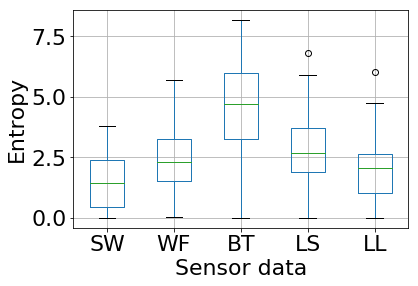

In [181]:
fig, ax = plt.subplots()
data2plot.boxplot(ax=ax)
ax.set_ylabel("Entropy")
ax.set_xlabel("Sensor data")
fig.savefig(get_plot_path("entropy-sensor-data"), format=plot_format, bbox_inches="tight")

This shows how the number of visited locations vary differently at different granularities. For example, GPS locations vary well in accordance with number of APs seen, but not the same between BT and Wi-Fi APs.

In [474]:
data2plot.corr()

,SW,WF,BT,LS,LL
SW,1.000000,0.410426,0.493709,0.731793,0.766488
WF,0.410426,1.000000,0.049099,0.185188,0.275352
BT,0.493709,0.049099,1.000000,0.619447,0.636795
LS,0.731793,0.185188,0.619447,1.000000,0.926490
LL,0.766488,0.275352,0.636795,0.926490,1.000000


## Location (Not usable as single result)
* Position (latitude, longitude) via provider: network or GPS and altitude
* Bearing in degress
* Speed in m/s over ground
* Altitude in m above sea level

In [962]:
# (lat, lng)
# entire garching campus
#left_top = (48.270989, 11.664961)
#left_bottom = (48.260646, 11.657456)
#right_bottom = (48.258208, 11.678250)
#right_top = (48.269283, 11.681646)

# smaller area only computer science campus
left_top = (48.263804, 11.666728)
left_bottom = (48.262156, 11.666374)
right_bottom = (48.261664, 11.669103)
right_top = (48.263565, 11.669849)

#import pyproj
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

coords = [left_top, left_bottom, right_bottom, right_top]

#p_ll = pyproj.Proj(init='epsg:4326')
#p_mt = pyproj.Proj(init='epsg:3857')
#for i, coord in enumerate(coords):
#    coords[i] = pyproj.transform(p_ll, p_mt, *coord)

polygon = Polygon(coords)
#plt.plot(*polygon.exterior.xy)
#plt.show()

subset = df_data["locations"][df_data["locations"].provider == "network"]
campus = list()
for lat, lng in zip(subset.lat, subset.lng):
    #lat, lng = pyproj.transform(p_ll, p_mt, lat, lng)
    point = Point(lat, lng)
    #point.within(polygon)
    if polygon.contains(point):
        campus.append((lat, lng))

print("total locations: {}".format(len(df_data["locations"].lat)))
print("campus locations: {}".format(len(campus)))

total locations: 1740816
campus locations: 29870


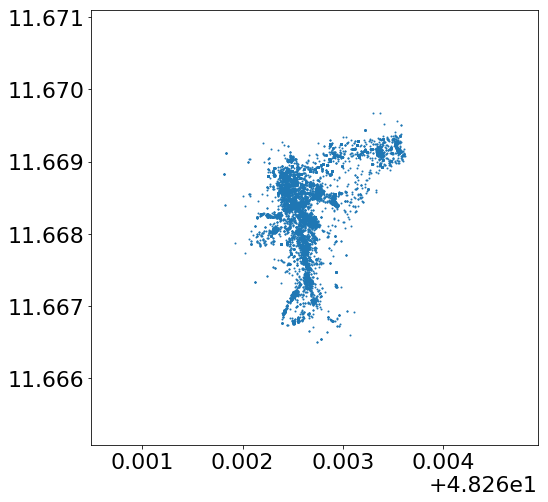

In [963]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*zip(*campus), s=1)

# Friends network (Future Work)
The following is the network of students as answered in the survey.

In [66]:
friends = pd.read_csv(os.path.join(path_data_collection, 'base_social_graph_df.csv'), index_col=0)

In [67]:
G = nx.from_numpy_matrix(friends.values)

In [68]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
pos = nx.spring_layout(G, k=1/1.2)

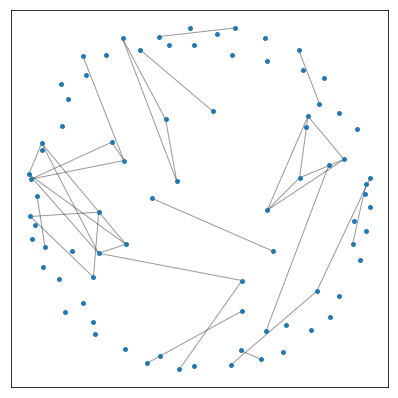

In [69]:
fig,ax = plt.subplots(figsize=(6,6))

nx.draw_networkx_nodes(G, pos, node_size=15, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()